In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

import sys
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv, AssignmentEnv, GameEnv
import pickle
from shortcut import multi_types
import numpy as np
import matplotlib.pyplot as plt
import collections

from shortcut import multi_types
from GameLearning import LRI, GameLearning, EXP3
from SA_baseline import recuit
from a_star import A_Star
from greedy_baseline import baseline, greedy

np.random.seed(42)

real_data = True

real = "real_" if real_data else ""

In [2]:
def moving_average(values, window, regret = False):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    vals = np.cumsum(1-values) if regret else values
    import pandas as pd
    rolled = pd.Series(vals).rolling(window)
    std = np.array(rolled.std())#/np.sqrt(window)
    mean = np.array(rolled.mean())
    min = np.array(rolled.min())
    max = np.array(rolled.max())
    # weights = np.repeat(1.0, window) / window
    return np.arange(len(mean)), mean, std, min, max#np.convolve(values, weights, "valid"), std

def plot_curve(x, y, std, min, max, title = "Learning Curve", label = None, marker = 'o'):
    fig = plt.figure(title)
    if label is None:
        label = 'mean rewards $\pm 2\sigma$'
    scatter_step = len(x)//10
    step = scatter_step//10
    p = plt.plot   (x[::step], y[::step])
    plt.plot(x[::step], np.maximum(y - 2*std, min)[::step], alpha = .2, color = p[-1].get_color(),)
    plt.plot(x[::step], np.minimum(y + 2*std, max)[::step], alpha = .2, color = p[-1].get_color(),)
    plt.fill_between(x[::step],
                     np.maximum(y - 2*std, min)[::step],
                     np.minimum(y + 2*std, max)[::step],
                     alpha=0.075, color=p[-1].get_color()
    )
    # plt.fill_between([x[0], x[-1]],
    #                  [np.maximum(y - 2*std, min)[0], np.maximum(y - 2*std, min)[-1]],
    #                  [np.minimum(y + 2*std, max)[0], np.minimum(y + 2*std, max)[-1]],
    #                  alpha=0.2, color=p[-1].get_color()
    # )
    plt.scatter(x[::scatter_step], y[::scatter_step],
                marker=marker,
                color = p[-1].get_color(),
                label=label
    )
    # plt.scatter([x[0], x[-1]],[y[0], y[-1]],
    #             marker=marker,
    #             color = p[-1].get_color(),
    #             # label=label
    # )
    plt.xlabel("Number of steps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")

<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\p'
/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_14797/3481770251.py:21: SyntaxWarning: invalid escape sequence '\p'
  label = 'mean rewards $\pm 2\sigma$'


In [3]:
def render_results(data, labels=None, K = 50):
    rewards = []
    times = []
    # omissions = []
    for k in data:
        ref = np.array([
                data[k][i]['r']
                for i in data[k].keys()
        ])
        print(np.mean(ref))
        break
    
    for k in data:
        rs = np.array([
            data[k][i]['r']
            for i in data[k].keys()
        ])
        rewards.append(rs
            #np.amin(np.where(cost==0, np.inf, cost), axis=1)
        )
        n = min(len(ref), len(rewards[-1]))
        rewards[-1][:n] /= ref[:n]
        
        time = [data[k][i]['time'] for i in data[k].keys()]# if d[i]['time'] < 50]
        times.append(time)
        
        # omissions.append(
        #     [
        #         len(d[i]['solution']) - np.count_nonzero(d[i]['solution'])
        #         for i in data[k].keys()
        #     ]
        # )
        
    plt.boxplot(
        times,
        labels=labels,
        patch_artist=True,
        )

    # plt.violinplot(
    #     times,
    #     # labels=labels,
    #     )
    plt.title(f'Times for different methods (in seconds), d = {K}')
    # plt.savefig('times.png')
    plt.show()
    
    plt.boxplot(
        rewards[1:],
        labels=labels[1:],
        patch_artist=True,
        )

    # plt.violinplot(
    #     rewards,
    #     # labels=labels,
    #     )
    plt.title(f'Relative performance compared to DP, d = {K}')
    plt.hlines(1, 1, len(rewards)-1, linestyles='--', colors='red')
    
    # plt.legend()
    # # plt.savefig('times.png')
    # plt.show()
    
    # plt.boxplot(
    #     omissions,
    #     labels=labels,
    #     patch_artist=True,
    #     )

    # # plt.violinplot(
    # #     omissions,
    # #     # labels=labels,
    # #     )
    # plt.title(f'Number of packages omitted, K = {K}')
    # plt.legend()
    # plt.savefig('times.png')
    # plt.show()
    # return times, rewards
    

In [4]:
# K = 30
# with open(f'RL/game_K{K}.pkl', 'rb') as f:
#     g = pickle.load(f)
# routes = np.load(f'RL/routes_K{K}.npy')
# dests = np.load(f'RL/destinations_K{K}.npy')

# with open(f'res_compare_EG_A*_SA_K{K}_n100.pkl', 'rb') as f:
#     data = pickle.load(f)
    
# print(g.Q)
# # if K == 100:
# #     g.Q = 40

In [5]:
K = 20
retain = 1.
retain_comment = f"_retain{retain}" if retain else ""

with open(f'RL/{real}game_K{K}{retain_comment}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'RL/real_routes_K{K}{retain_comment}.npy')
dests = np.load(f'RL/real_destinations_K{K}{retain_comment}.npy')

print(g.Q)

flag_break = False
for Q in range(g.Q, 0, -1):
    for i in range(200):
        g.Q = Q
        env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                          obs_mode='elimination_gain', 
                          action_mode = 'destinations',
                            change_instance = False, rewards_mode='normalized_terminal', instance_id = i)
        _, info = env.reset()
        if info['excess_emission'] <= 1e-5:
            flag_break = True
            # print(i)
            # print(info)
            # print(info['excess_emission'])
            # print(np.sum(info['distance_per_vehicle']*g.emissions_KM))
            break
    if not flag_break:
        print(Q)
        break
    flag_break = False
        

300
300


In [6]:
(routes[0]>=0).all()

np.True_

In [7]:
# g.Q = 300
# with open(f'RL/real_game_K{g.num_packages}{retain_comment}.pkl', 'wb') as f:
#     pickle.dump(g, f, -1)

In [8]:
# rewards = []
# # data['res_DP'][84]['sol'] = data['res_SA'][84]['sol']
# for k in data.keys():
#     rs = np.zeros(len(data[k]))
#     for i in data[k].keys():
#         sol = data[k][i]['sol']
#         env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
#                       obs_mode='elimination_gain', 
#                       action_mode = 'destinations',
#                         change_instance = True, rewards_mode='normalized_terminal', instance_id = int(i))
#         env.reset()
#         _, r, *_ = env.step(sol)
#         if r == 0:
#             print(k)
#             print(i)
#             print(sol)
#         rs[i] = r
#     rewards.append(rs)

In [9]:
# rr = []
# for rs in rewards:
#     rr.append(rs/(rewards[0]))
    
# plt.boxplot(
#         rr,
#         patch_artist=True,
#         )
# plt.show()

In [10]:
# print(np.where(rr[1]>1))
# print(np.where(rr[2]>1))
# print(np.where(rr[3]>1))

In [11]:
# env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
#                       obs_mode='elimination_gain', 
#                       action_mode = 'destinations',
#                         change_instance = False, rewards_mode='normalized_terminal', instance_id = 89)
# _, info = env.reset()
# excess = info['excess_emission']

# rtes = np.array([
#     [
#         env._env.initial_routes[m, i] 
#         for i in range(0, len(env._env.initial_routes[m]), 2)
#     ]
#     for m in range(len(env._env.initial_routes))
# ], dtype=int)

# print(rtes)

# print(env._env.distance_matrix)
# # print(CM)
# coeff = env._env._game.emissions_KM
# # CM = np.array([
# #     env._env.distance_matrix*coeff[i]
# #     for i in range(len(coeff))
# # ]).copy()
# a = multi_types(env._env.distance_matrix, rtes, coeff, excess)


# _, r, *_ = env.step(a)
# print(r)
# print(rewards[0][89])
# print(a)
# print(data['res_DP'][89]['sol'])


In [12]:
# env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
#                     obs_mode='elimination_gain', 
#                     action_mode = 'destinations',
#                     change_instance = False, rewards_mode='normalized_terminal', instance_id = 89
# )
# _, info = env.reset()
# excess = info['excess_emission']
# T_init = 5_000
# T_limit = 1
# lamb = 0.9999
# T = 100_000

# action_SA, *_ = recuit(deepcopy(env._env), T_init, T_limit, lamb, H=T)
#         # res = recuit_multiple(game, T_init = T_init, T_limit = T_limit, lamb = lamb, log=log, H=T)
# a = np.where(action_SA == 0)[0]

# print(excess)

# print(env._env.distance_matrix)
# # print(CM)
# coeff = env._env._game.emissions_KM
# # CM = np.array([
# #     env._env.distance_matrix*coeff[i]
# #     for i in range(len(coeff))
# # ]).copy()
# a = multi_types(env._env.distance_matrix, rtes, coeff, excess)

# # env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
# #                       obs_mode='elimination_gain', 
# #                       action_mode = 'destinations',
# #                         change_instance = True, rewards_mode='normalized_terminal', instance_id = 89)

# env.reset()
# _, r, *_, info = env.step(75)
# print(r)

# env.reset()
# _, r, *_, info = env.step(a)
# print(info['excess_emission'])

# print(r)
# print(rewards[1][89])
# print(a)
# print(data['res_SA'][89]['sol'])

In [13]:
# with open('res_GameLearning_EXP3_K100_n50_tsp.pkl', 'rb') as f:
#     dataEXPTSPn50 = pickle.load(f)
    
# with open('res_GameLearning_EXP3_K100_n100_tsp.pkl', 'rb') as f:
#     dataEXPTSPn100 = pickle.load(f)

# # with open('res_GameLearning_LRI_K100_n50_vrp.pkl', 'rb') as f:
# #     dataLRI = pickle.load(f)
    
# # with open('res_GameLearning_LRI_K100_n50_tsp.pkl', 'rb') as f:
# #     dataLRITSP = pickle.load(f)
    
# expn50 = {
#     i : {
#         'r' : np.max(dataEXPTSPn50[i]['rewards']),
#         'time' : dataEXPTSPn50[i]['time']
#     }
#     for i in dataEXPTSPn50.keys()
# }

# expn100 = {
#     i : {
#         'r' : np.max(dataEXPTSPn100[i]['rewards']),
#         'time' : dataEXPTSPn100[i]['time']
#     }
#     for i in dataEXPTSPn100.keys()
# }

# # lriTSP2 = {
# #     i : {
# #         'r' : np.max(dataLRITSP[i]['rewards']),
# #         'time' : dataLRITSP[i]['time']
# #     }
# #     for i in dataLRITSP.keys()
# # }

# # lri = {
# #     i : {
# #         'r' : np.max(dataLRI[i]['rewards']),
# #         'time' : dataLRI[i]['time']
# #     }
# #     for i in dataLRI.keys()
# # }

# data = {
#     'EXP3 n50' : expn50,
#     'EXP3 n100' : expn100,
#     # 'LRI TSP2' : lriTSP2,
#     # 'EGreedy TSP2' : lri,
# }
# render_results(data, labels=['EXP3 n50', 'EXP3 n100'])#, 'LRI TSP', 'EGreedy TSP2'])

In [14]:
# with open(f'RL/{real}res_GameLearning_EXP3_K50_n100_vrp.pkl', 'rb') as f: dataEXP = pickle.load(f)
with open(f'{real}res_GameLearning_EXP3_K50_n100_tsp.pkl', 'rb') as f: dataEXPTSP = pickle.load(f)
# with open(f'RL/{real}res_GameLearning_LRI_K50_n100_vrp.pkl', 'rb') as f: dataLRI = pickle.load(f)
with open(f'{real}res_GameLearning_LRI_K50_n100_tsp.pkl', 'rb') as f: dataLRITSP = pickle.load(f)
with open(f'{real}res_SA_TSP_K50_n100.pkl', 'rb') as f: dataSATSP = pickle.load(f)

In [15]:

# exp = {
#     i : {
#         'r' : np.max(dataEXP[i]['rewards']),
#         'time' : dataEXP[i]['time']
#     }
#     for i in dataEXP.keys()
# }

expTSP = {
    i : {
        'r' : np.max(dataEXPTSP[i]['rewards']),
        'time' : dataEXPTSP[i]['time']
    }
    for i in dataEXPTSP.keys()
}

# lri = {
#     i : {
#         'r' : np.max(dataLRI[i]['rewards']),
#         'time' : dataLRI[i]['time']
#     }
#     for i in dataLRI.keys()
# }

lriTSP = {
    i : {
        'r' : np.max(dataLRITSP[i]['rewards']),
        'time' : dataLRITSP[i]['time']
    }
    for i in dataLRITSP.keys()
}

# saTSP = {
#     i : {
#         'r' : dataSATSP[i]['r'],
#         'time' : dataSATSP[i]['time']
#     }
#     for i in dataSATSP.keys()
# }


In [16]:
dataEXPTSP[1]['solution']

array([1, 1, 2, 3, 3, 1, 2, 3, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 3,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0])

Text(0.5, 1.0, 'Evolution of the average best reward by EXP3, d = 100')

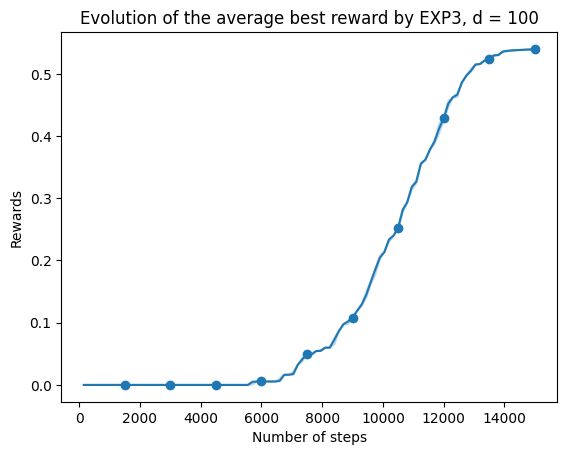

In [17]:
with open(f'{real}res_GameLearning_EXP3_K100_n100_tsp.pkl', 'rb') as f:
    EXPTSP = pickle.load(f)
    
plot_curve(*moving_average(np.mean([np.maximum.accumulate(np.array(EXPTSP[i]['rewards'])) for i in EXPTSP.keys()], axis=0), 50))
plt.title("Evolution of the average best reward by EXP3, d = 100")
# plt.plot()
# print(np.mean([expTSP[i]['r'] for i in dataEXPTSP2.keys()]))
# print([dataEXPTSP[i]['solution'] for i in dataEXPTSP2.keys()])

Text(0.5, 1.0, 'Evolution of the average best reward by EXP3, d = 20')

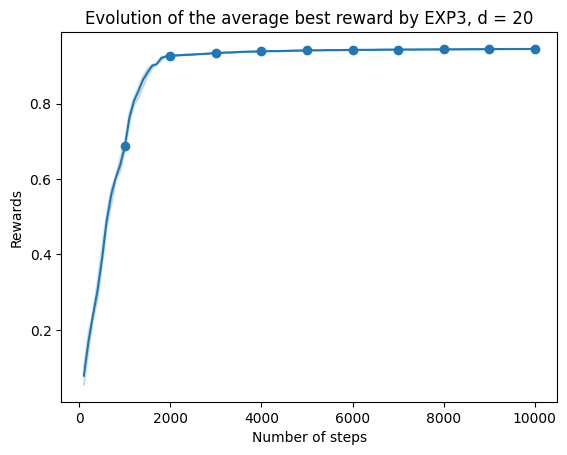

In [18]:
with open(f'{real}res_GameLearning_EXP3_K20_n100_tsp.pkl', 'rb') as f:
    EXPTSP = pickle.load(f)
    
plot_curve(*moving_average(np.mean([np.maximum.accumulate(np.array(EXPTSP[i]['rewards'])) for i in EXPTSP.keys()], axis=0), 50))
plt.title("Evolution of the average best reward by EXP3, d = 20")

Text(0.5, 1.0, 'Evolution of the average best reward by EXP3, d = 50')

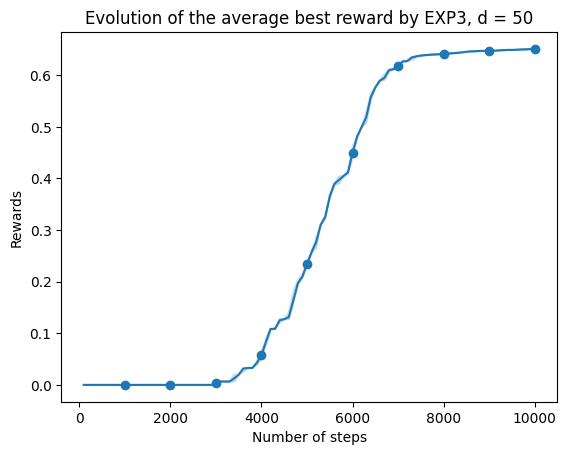

In [19]:
with open(f'{real}res_GameLearning_EXP3_K50_n100_tsp.pkl', 'rb') as f:
    EXPTSP = pickle.load(f)
    
plot_curve(*moving_average(np.mean([np.maximum.accumulate(np.array(EXPTSP[i]['rewards'])) for i in EXPTSP.keys()], axis=0), 50))
plt.title("Evolution of the average best reward by EXP3, d = 50")

In [20]:
np.argmax([EXPTSP[i]['rewards'] for i in EXPTSP.keys()], axis=1)

array([8320, 8086, 7965, 6679, 9226, 6994, 7700, 8800, 9614, 8891, 7572,
       7941, 8103, 7108, 3807, 8510, 9431, 6860, 6206, 6958, 9812, 6821,
       9658, 8807, 5927, 3370, 8159, 7204, 6673, 3999, 7363, 9155, 9370,
       7402, 7384, 7909, 8540, 9357, 5921, 6981, 7265, 9316, 8369, 9965,
       6641, 6306, 8944, 5930, 8623, 7383, 5625, 4987, 6323, 8756, 9815,
       5684, 6506, 8133, 9584, 9915, 4927, 6520, 9411, 9704, 8745, 5596,
       6655, 8267, 9220, 8087, 7354, 6483, 4934, 3560, 7438, 6996, 8424,
       8411, 8182, 7623, 7931, 9064, 9158, 8244, 9544, 9260, 8558, 7021,
       8347, 8250, 5493, 7521, 5854, 9108, 7322, 6715, 9945, 8535, 8600,
       8516])

In [21]:
# with open('res_compare_EG_A*_SA_K50_n500_T100000.pkl', 'rb') as f:
#     dataaa = pickle.load(f)

# data['res_greedy'] = dataaa['res_greedy']
# with open(f"res_compare_EG_A*_SA_K50_n500.pkl","wb") as f:
#         pickle.dump(data, f)

dict_keys(['res_DP', 'res_SA', 'res_greedy'])
0.7506499764262141


/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_14797/2542899798.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


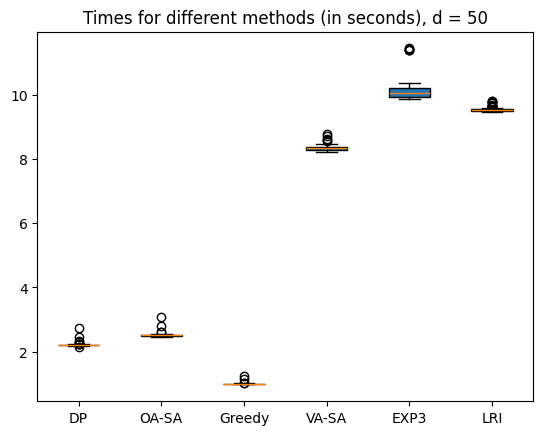

/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_14797/2542899798.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


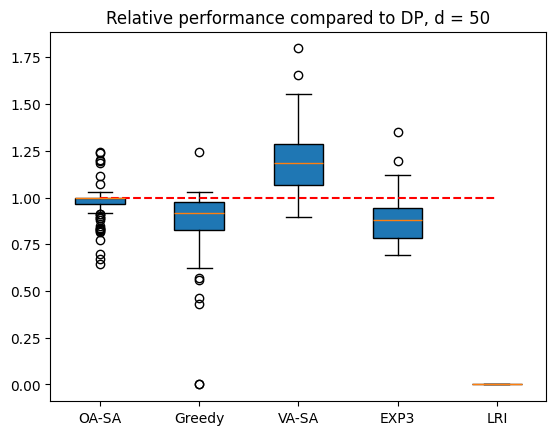

In [22]:
with open(f'{real}res_compare_EG_A*_SA_K50_n100.pkl', 'rb') as f:
    data = pickle.load(f)
    

print(data.keys())
data['SA TSP'] = dataSATSP['res_SA']
# data['EXP'] = exp
data['EXP TSP'] = expTSP
# data['LRI'] = lri
data['LRI TSP'] = lriTSP
# del data['res_A']
render_results(data, labels=['DP', 'OA-SA', 'Greedy','VA-SA',  'EXP3', 'LRI'])
# render_results([data])

In [23]:
with open(f'{real}res_compare_EG_A*_SA_K100_n100.pkl', 'rb') as f: data100 = pickle.load(f)
# with open(f'{real}res_GameLearning_EXP3_K100_n100_vrp.pkl', 'rb') as f: dataEXP100 = pickle.load(f)
with open(f'{real}res_GameLearning_EXP3_K100_n100_tsp.pkl', 'rb') as f: dataEXP3TSP100 = pickle.load(f)
# with open(f'{real}res_GameLearning_LRI_K100_n100_vrp.pkl', 'rb') as f: dataLRI100 = pickle.load(f)
with open(f'{real}res_GameLearning_LRI_K100_n100_tsp.pkl', 'rb') as f: dataLRITSP100 = pickle.load(f)
with open(f'{real}res_SA_TSP_K100_n100.pkl', 'rb') as f: dataSATSP100 = pickle.load(f)

In [24]:
# exp100 = {
#     i : {
#         'r' : np.max(dataEXP100[i]['rewards']),
#         'time' : dataEXP100[i]['time']
#     }
#     for i in dataEXP100.keys()
# }

expTSP100 = {
    i : {
        'r' : np.max(dataEXP3TSP100[i]['rewards']),
        'time' : dataEXP3TSP100[i]['time']
    }
    for i in dataEXP3TSP100.keys()
}

# lri100 = {
#     i : {
#         'r' : np.max(dataLRI100[i]['rewards']),
#         'time' : dataLRI100[i]['time']
#     }
#     for i in dataLRI100.keys()
# }

lriTSP100 = {
    i : {
        'r' : np.max(dataLRITSP100[i]['rewards']),
        'time' : dataLRITSP100[i]['time']
    }
    for i in dataLRITSP100.keys()
}

data100['SA TSP'] = dataSATSP100['res_SA']
# data100['EXP3'] = exp100
data100['EXP3 TSP'] = expTSP100
# data100['LRI'] = lri100
data100['LRI TSP'] = lriTSP100

In [25]:
# np.argmax(dataLRITSP100[0]['rewards'])

In [26]:
# dataLRITSP100[0]['solution']

In [27]:
# astar = np.array([
#                 data['res_A'][i]['r']
#                 for i in data['res_A'].keys()
#         ])


# gts = np.array([
#                 data['res_greedy'][i]['r']
#                 for i in data['res_greedy'].keys()
#         ])

# (gts == astar).all()
# del data100['res_A']


dict_keys(['res_DP', 'res_SA', 'res_greedy', 'SA TSP', 'EXP3 TSP', 'LRI TSP'])
0.8322809523809523


/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_14797/2542899798.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


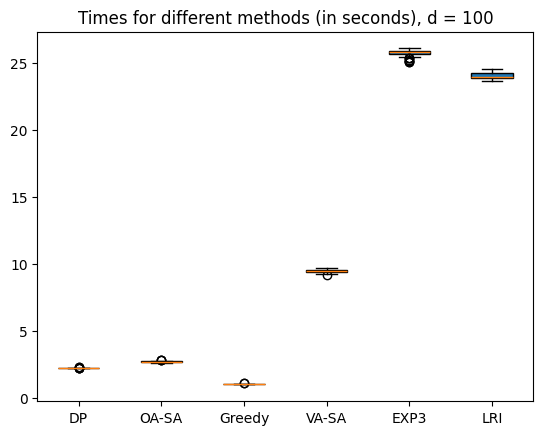

/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_14797/2542899798.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


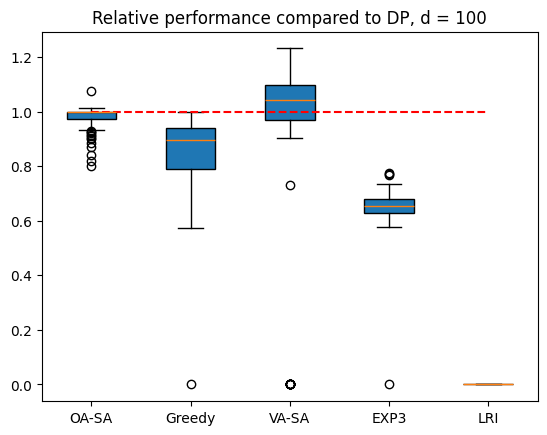

In [28]:
# del data100['res_A']
print(data100.keys())
render_results(data100, labels=['DP', 'OA-SA', 'Greedy','VA-SA',  'EXP3', 'LRI'], K = 100)
# render_results(data100, labels=['DP', 'SA', 'A*', 'GTS', 'SA TSP', 'EXP3', 'LRI'], K = 100)
# render_results(data100, labels=['DP', 'SA', 'A*', 'GTS'], K = 100)

In [29]:
with open(f'{real}res_compare_EG_A*_SA_K20_n100_retain1.0.pkl', 'rb') as f: data20 = pickle.load(f)
with open(f'{real}res_GameLearning_EXP3_K20_n100_tsp.pkl', 'rb') as f: dataEXP3TSP20 = pickle.load(f)
with open(f'{real}res_SA_TSP_K20_n100_retain1.0.pkl', 'rb') as f:
    dataSATSP20 = pickle.load(f)
    
expTSP20 = {
    i : {
        'r' : np.max(dataEXP3TSP20[i]['rewards']),
        'time' : dataEXP3TSP20[i]['time']
    }
    for i in dataEXP3TSP20.keys()
}

del data20['res_DP']

data20['SA TSP'] = dataSATSP20['res_SA']
data20['EXP3 TSP'] = expTSP20

0.7026276430994473


/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_14797/2542899798.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


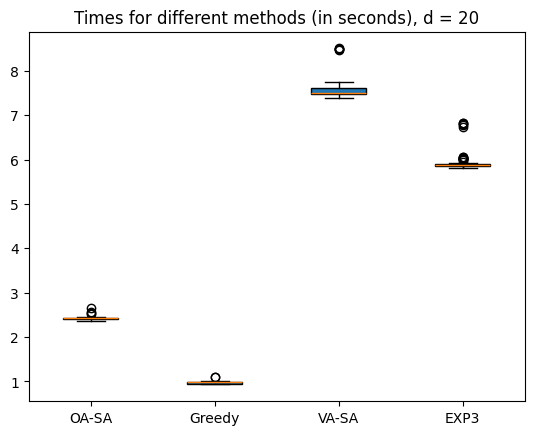

/var/folders/6y/xmdymgfj6t79xkdq239jvsmm0000gn/T/ipykernel_14797/2542899798.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


Text(0.5, 1.0, 'Relative performance compared to OA-SA, d = 20')

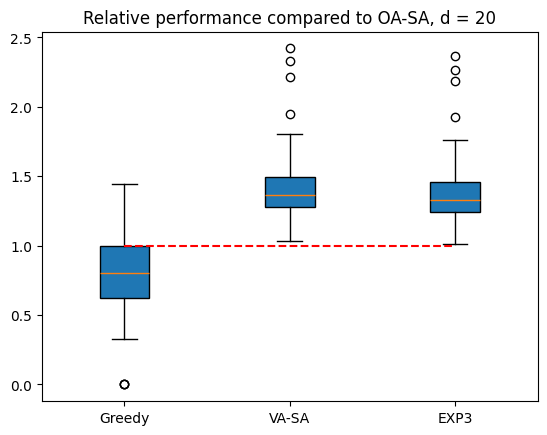

In [30]:
render_results(data20, labels=['OA-SA', 'Greedy', 'VA-SA', 'EXP3'], K = 20)
plt.title(f'Relative performance compared to OA-SA, d = {20}')

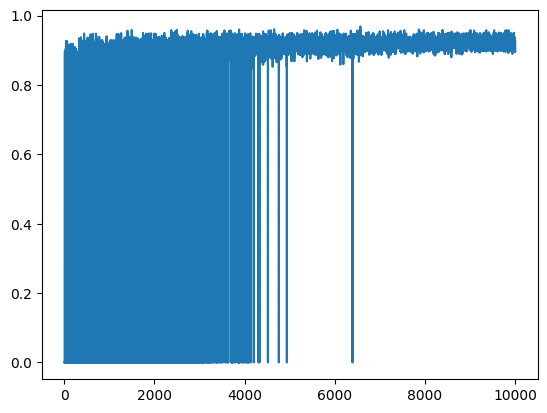

In [31]:
plt.plot(np.maximum(0, np.max([dataEXP3TSP20[i]['rewards'][1:] for i in dataEXP3TSP20.keys()], axis=0)))

In [32]:
dataEXP3TSP20[0]['solution']

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 1])

{'whiskers': [<matplotlib.lines.Line2D at 0x12f018ec0>,
 'caps': [<matplotlib.lines.Line2D at 0x12f0188c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f019280>,
 'medians': [<matplotlib.lines.Line2D at 0x12f0181a0>,
 'fliers': [<matplotlib.lines.Line2D at 0x12f018350>,
 'means': []}

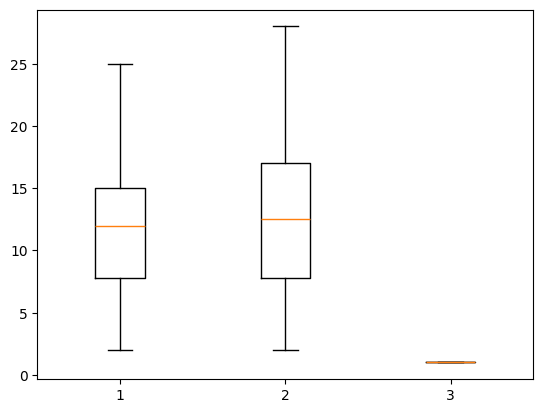

In [33]:
omissions = []
omissions.append([len(data['res_DP'][i]['sol']) for i in data['res_DP'].keys()])
omissions.append([len(data['res_SA'][i]['sol']) for i in data['res_SA'].keys()])
omissions.append([len(np.where(data['SA TSP'][i]['sol'] == 0)) for i in data['res_SA'].keys()])
plt.boxplot(omissions)

In [34]:
r_expTSP = np.array([expTSP[i]['r'] for i in expTSP.keys()])
r_SA = np.array([data['res_SA'][i]['r'] for i in data['res_SA'].keys()])
r_DP = np.array([data['res_DP'][i]['r'] for i in data['res_DP'].keys()])

{'whiskers': [<matplotlib.lines.Line2D at 0x12e718320>,
 'caps': [<matplotlib.lines.Line2D at 0x12e718920>,
 'boxes': [<matplotlib.lines.Line2D at 0x12e718560>],
 'medians': [<matplotlib.lines.Line2D at 0x12e71aae0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12e71a8d0>],
 'means': []}

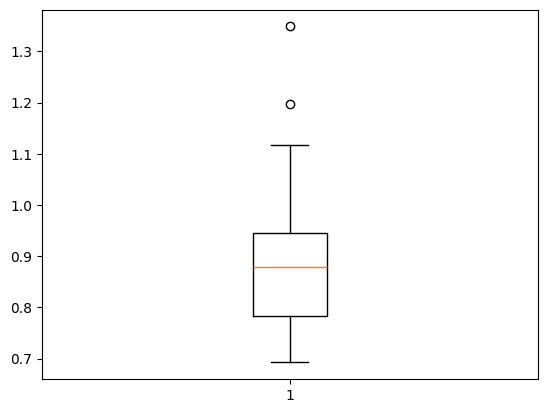

In [35]:
plt.boxplot(r_expTSP/r_DP)

In [36]:
instance = np.argmax(r_expTSP/r_DP)
print(r_expTSP[instance])
print(r_DP[instance])
print(instance)

0.6541914191419141
0.48507307873644506
65


(4, 17)


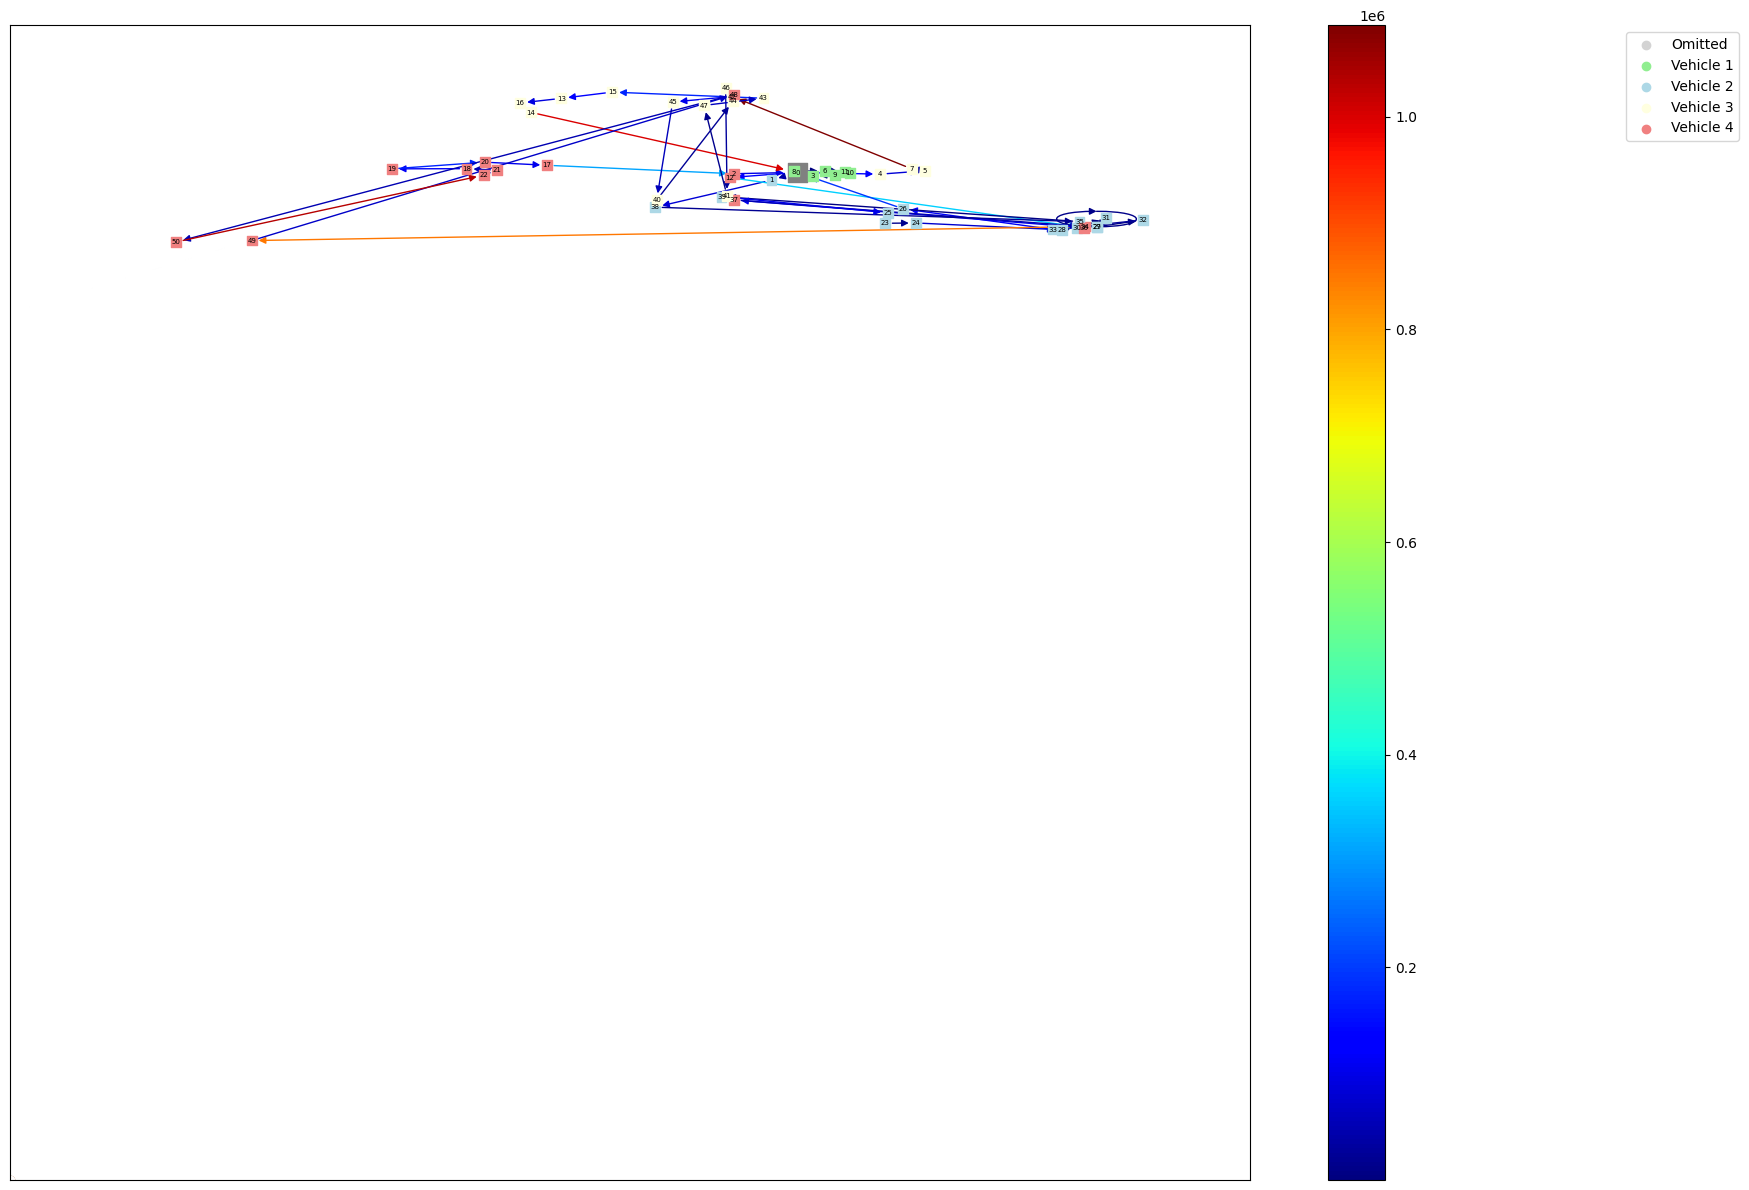

{'solution_found': np.True_, 'costs': np.float64(3082.0), 'time_per_vehicle': <built-in function time>, 'distance_per_vehicle': array([  79.,  760., 1052., 1191.]), 'excess_emission': np.float64(398.9), 'omitted': array([], dtype=int64)}
----------------------------------------------------------------------------------------------------
{'LCF': array([  26780., 1032388., 2205735.,  267089.]), 'r': np.float64(-34992.0), 'a': array([4, 2, 4, 1, 1, 2, 1, 1, 1, 2, 3, 1, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 2, 1, 3, 2, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]), 'routes': array([[ 0,  8,  9,  4,  5,  7, 12, 36, 34, 39, 23, 24, 33, 18, 20, 19,
         0],
       [ 0,  6, 10,  2, 17, 21, 22, 38, 35, 26, 25, 28, 31, 27, 29, 32,
         0],
       [ 0, 11, 37, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0]]), 'costs per vehicle': array([1328., 1025.,  735.

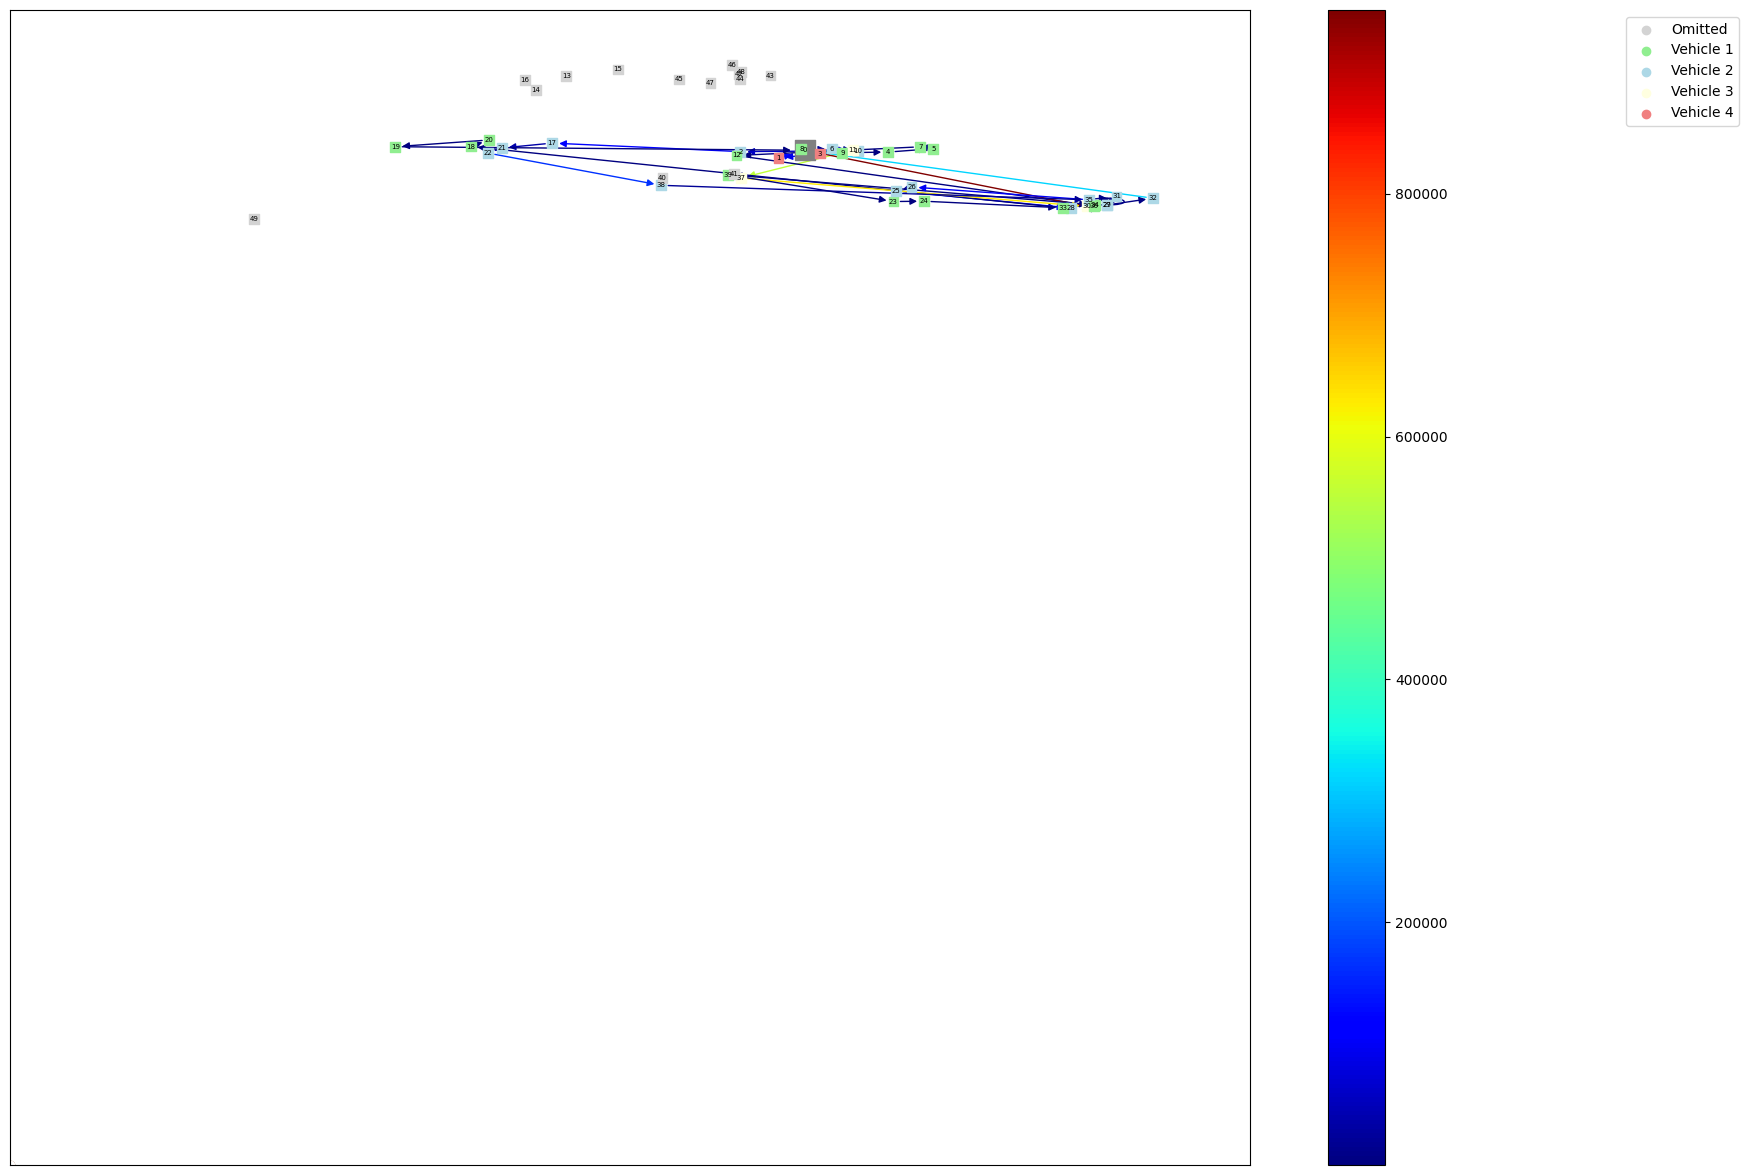

{'LCF': array([   5232.,  572166., 2892964.,       0.]), 'r': np.float64(-17362.0), 'a': array([2, 1, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 3, 3, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 3,
       3, 3, 3, 0, 0, 0]), 'routes': array([[ 0,  2, 17, 21, 22, 26, 25, 23, 24, 28, 30, 31, 27, 29, 32, 33,
         0],
       [ 0,  3,  9, 10, 11,  4,  5,  7,  1, 12, 38, 35, 39, 37, 34, 36,
         0],
       [ 0,  8,  6, 14, 16, 13, 15, 47, 41, 46, 44, 40, 45, 42,  0,  0,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0]]), 'costs per vehicle': array([990., 561., 964.,   0.]), 'omitted': array([17, 18, 19, 42, 47, 48, 49]), 'excess_emission': np.float64(-4.700010000000045)}
0.8362847713342763
(4, 17)


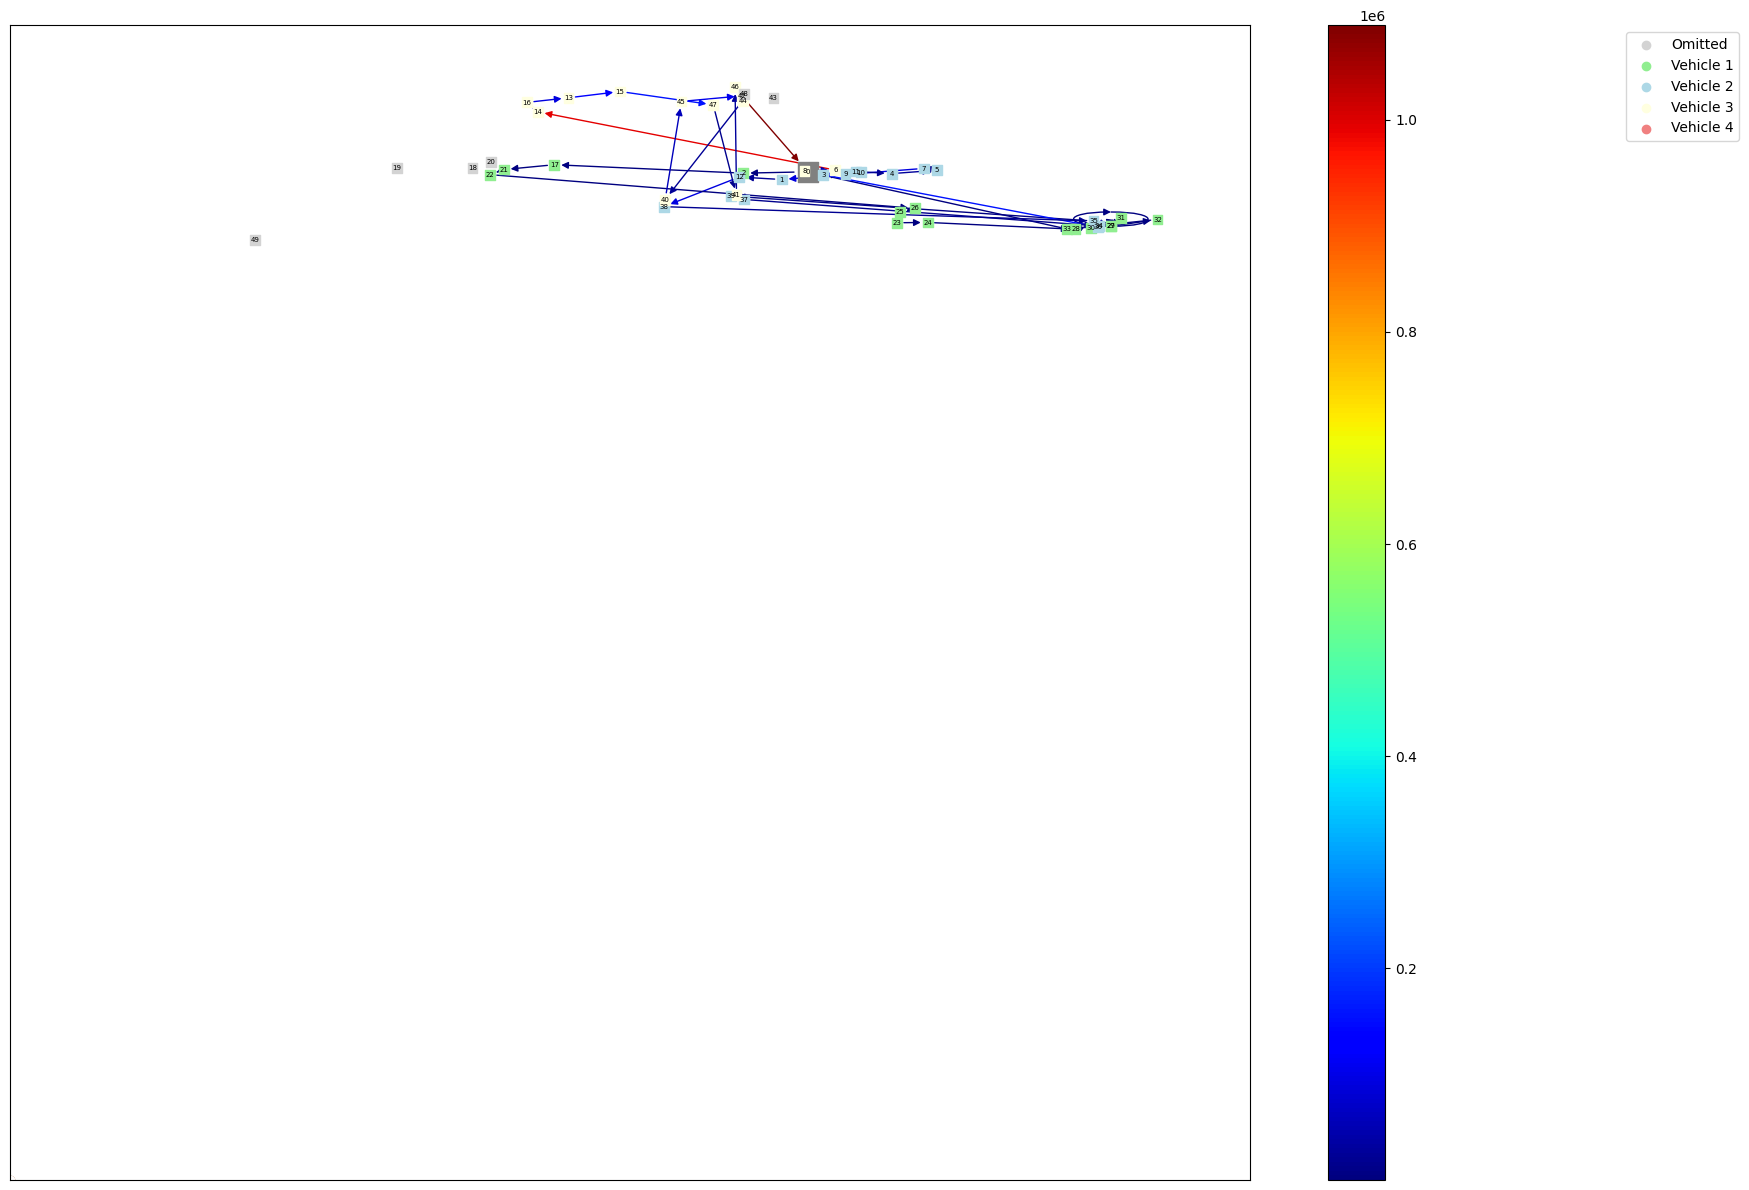

'\\documentclass{report}\n\\usepackage{tikz}\n\\usepackage{subcaption}\n\n\\begin{document}\n\\begin{figure}\n  \\begin{tikzpicture}\n      \\draw\n        (5.246, 46.205) node[gray] (0){0}\n        (5.073, 45.853) node[lightblue] (1){1}\n        (4.821, 46.145) node[lightgreen] (2){2}\n        (5.347, 46.054) node[lightblue] (3){3}\n        (5.796, 46.124) node[lightblue] (4){4}\n        (6.094, 46.277) node[lightblue] (5){5}\n        (5.427, 46.284) node[lightyellow] (6){6}\n        (6.008, 46.362) node[lightblue] (7){7}\n        (5.223, 46.251) node[lightyellow] (8){8}\n        (5.493, 46.093) node[lightblue] (9){9}\n        (5.595, 46.179) node[lightblue] (10){10}\n        (5.563, 46.218) node[lightblue] (11){11}\n        (4.795, 45.967) node[lightblue] (12){12}\n        (3.672, 49.599) node[lightyellow] (13){13}\n        (3.47, 48.958) node[lightyellow] (14){14}\n        (4.011, 49.886) node[lightyellow] (15){15}\n        (3.399, 49.388) node[lightyellow] (16){16}\n        (3.578,

In [37]:
K = 50
# # make_different_sims(K = K, strategy = LRI, n_simulation=100, T=10_000, log=False, tsp=True, comment = '_tsp')
# # make_different_sims(K = K, strategy = LRI, n_simulation=100, T=10_000, log=False, tsp=False, comment = '_vrp')
# make_different_sims(K = K, strategy = EXP3, n_simulation=100, T=10_000, log=False, tsp=True, comment = '_tsp')
# K = 30
# make_different_sims(K = K, strategy = EXP3, n_simulation=100, T=10_000, log=False, tsp=True, comment = '_tsp')
# make_different_sims(K = K, strategy = EXP3, n_simulation=100, T=10_000, log=False, tsp=False, comment = '_vrp')
# game = AssignmentEnv(obs_mode='game')
# game.reset()
# with open(f'RL/game_K{K}_retain1.0.pkl', 'rb') as f:
#     g = pickle.load(f)
# routes = np.load(f'RL/routes_K{K}_retain1.0.npy')
# dests = np.load(f'RL/destinations_K{K}_retain1.0.npy')
# qs = np.load(f'RL/quantities_K{K}_retain1.0.npy')
# env = GameEnv(AssignmentEnv(game=deepcopy(g), saved_routes=routes, saved_dests=dests, saved_q=qs, obs_mode='game', instance_id=instance, change_instance=False))

instance = 40

with open(f'RL/{real}game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'RL/{real}routes_K{K}.npy')
dests = np.load(f'RL/{real}destinations_K{K}.npy')
env = GameEnv(AssignmentEnv(game=deepcopy(g), saved_routes=routes, saved_dests=dests, obs_mode='game', instance_id=instance, change_instance=False))
_, info = env.reset()
env.render()
# env.render()
print(info)
print(100*'-')
action = dataEXPTSP[instance]['solution']
# action = np.zeros(K, dtype=int)
# print(np.sum(env._env.quantities[np.where(action==0)[0]]))
*_, info = env.step(action)
nrmlz = np.sum(env.quantities)*env.omission_cost
print(info)
print((nrmlz + info['r'])/nrmlz)
print(data['res_DP'][instance]['r'])
env.render()

action = dataSATSP['res_SA'][instance]['sol']
# action = np.zeros(K, dtype=int)
# print(np.sum(env._env.quantities[np.where(action==0)[0]]))
*_, info = env.step(action)
nrmlz = np.sum(env.quantities)*env.omission_cost
print(info)
print((nrmlz + info['r'])/nrmlz)
# print(data['res_DP'][instance]['r'])
env.render()

(4, 27)


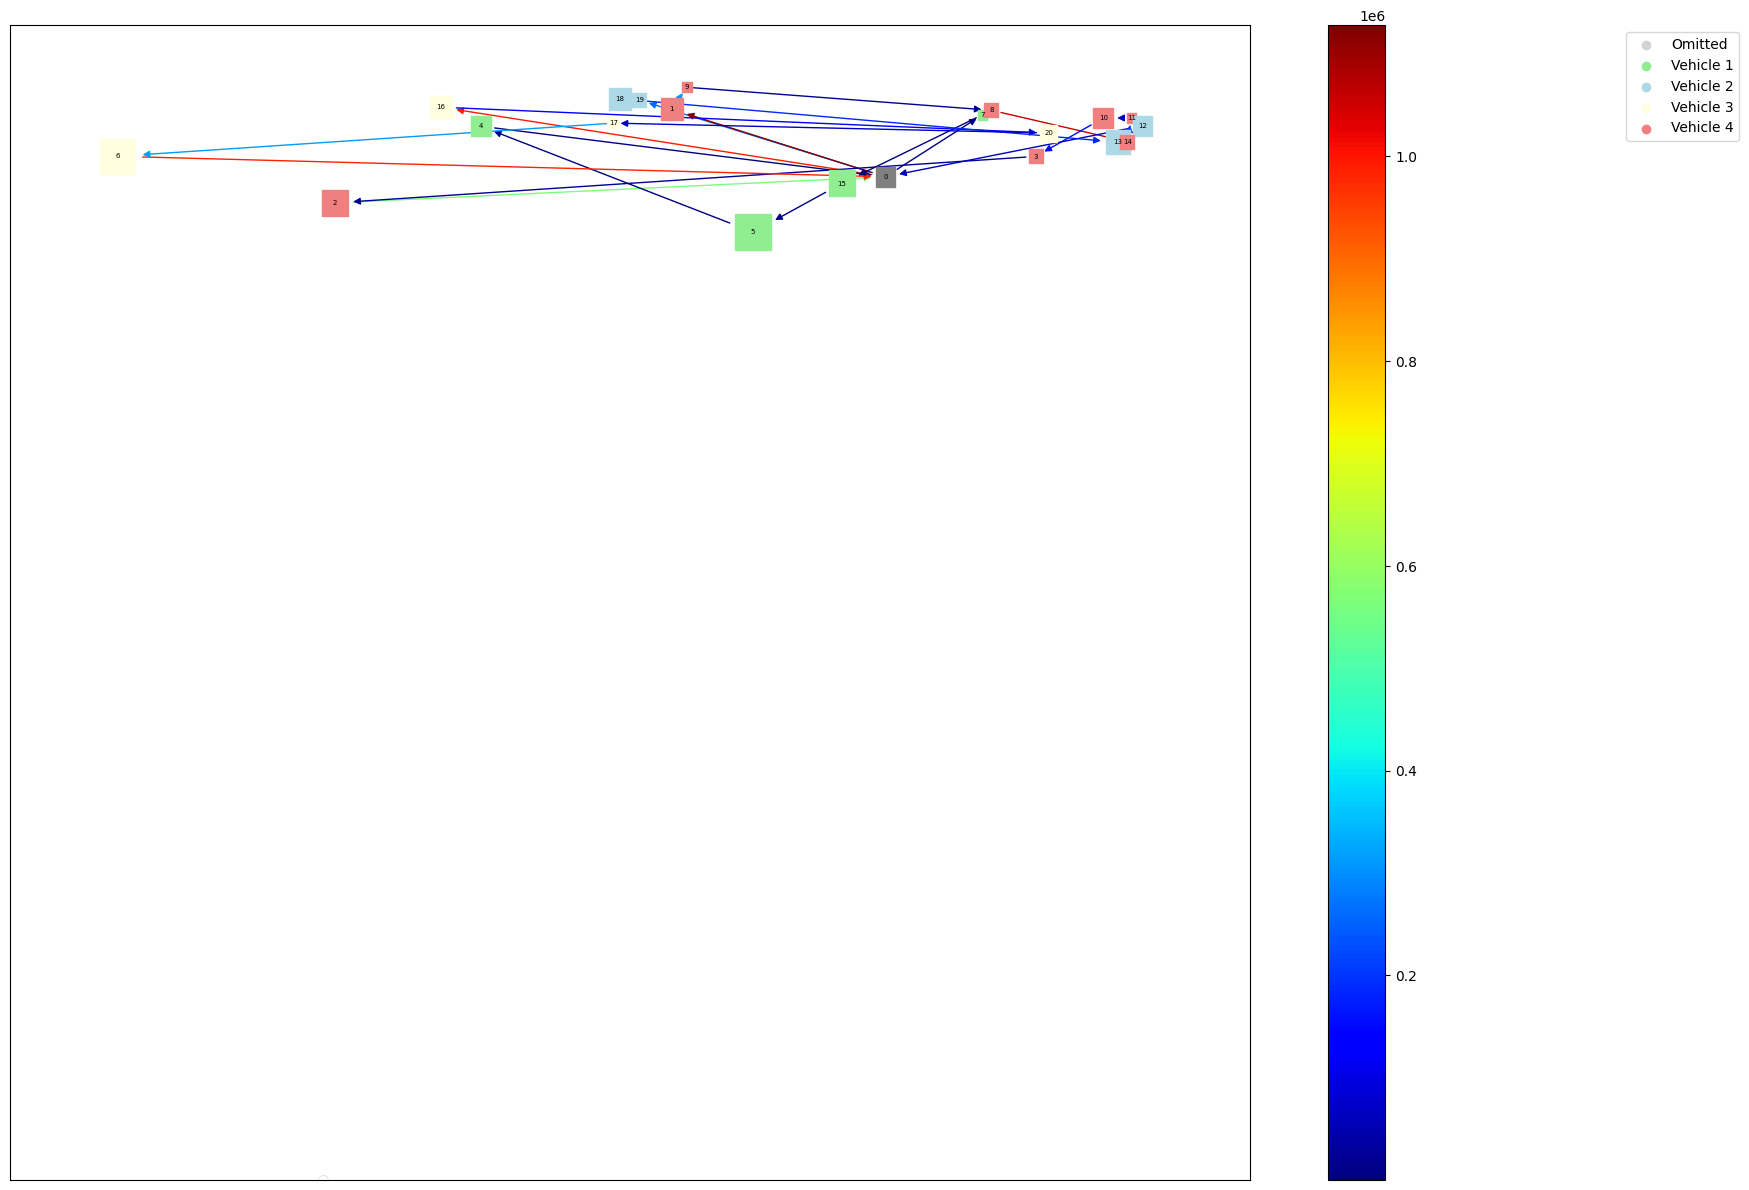

{'solution_found': np.True_, 'costs': np.float64(3757.0), 'time_per_vehicle': <built-in function time>, 'distance_per_vehicle': array([1182.,  568.,  830., 1177.]), 'excess_emission': np.float64(358.9), 'omitted': array([], dtype=int64)}
{'LCF': array([  44141., 1299844., 1512504.,       0.]), 'r': np.float64(-9859.0), 'a': array([2, 1, 1, 1, 0, 0, 2, 1, 2, 2, 1, 1, 3, 2, 0, 2, 1, 3, 1, 2]), 'routes': array([[ 0, 12, 19,  3,  2, 11,  8, 17,  4,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7, 16, 20,  1,  9, 14, 10,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 13, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]), 'costs per vehicle': array([1721., 1271.,  504.,    0.]), 'omitted': array([ 4,  5, 14]), 'ex

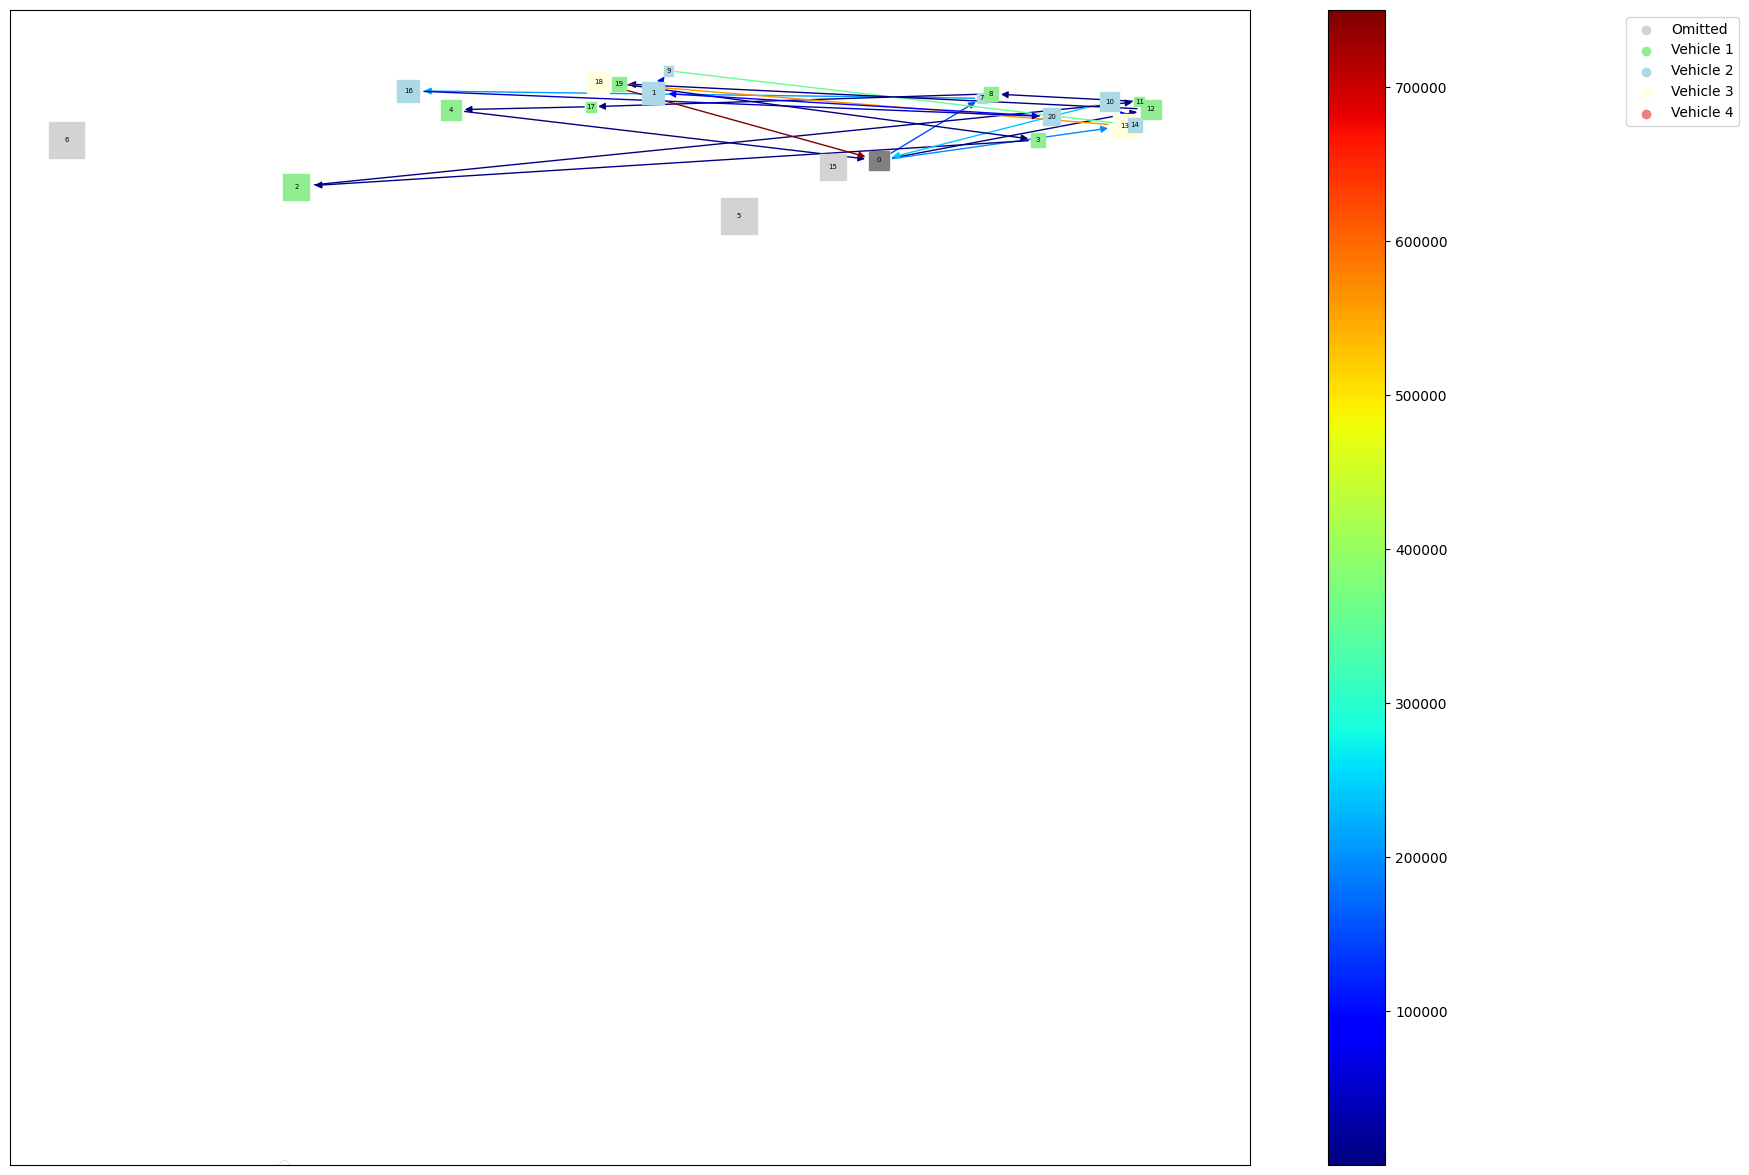

{'LCF': array([1.219000e+03, 1.083082e+06, 0.000000e+00, 1.759714e+06]), 'r': np.float64(-7111.0), 'a': array([1, 1, 1, 2, 0, 0, 2, 1, 1, 1, 1, 4, 4, 1, 2, 2, 2, 4, 4, 2]), 'routes': array([[ 0, 14,  2,  3, 11, 10,  1,  9,  8,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7, 16, 20, 17,  4, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 12, 13, 18, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]), 'costs per vehicle': array([1219., 1082.,    0.,  568.]), 'omitted': array([4, 5]), 'excess_emission': np.float64(-21.400009999999977)}
0.9619015472975869
(4, 27)


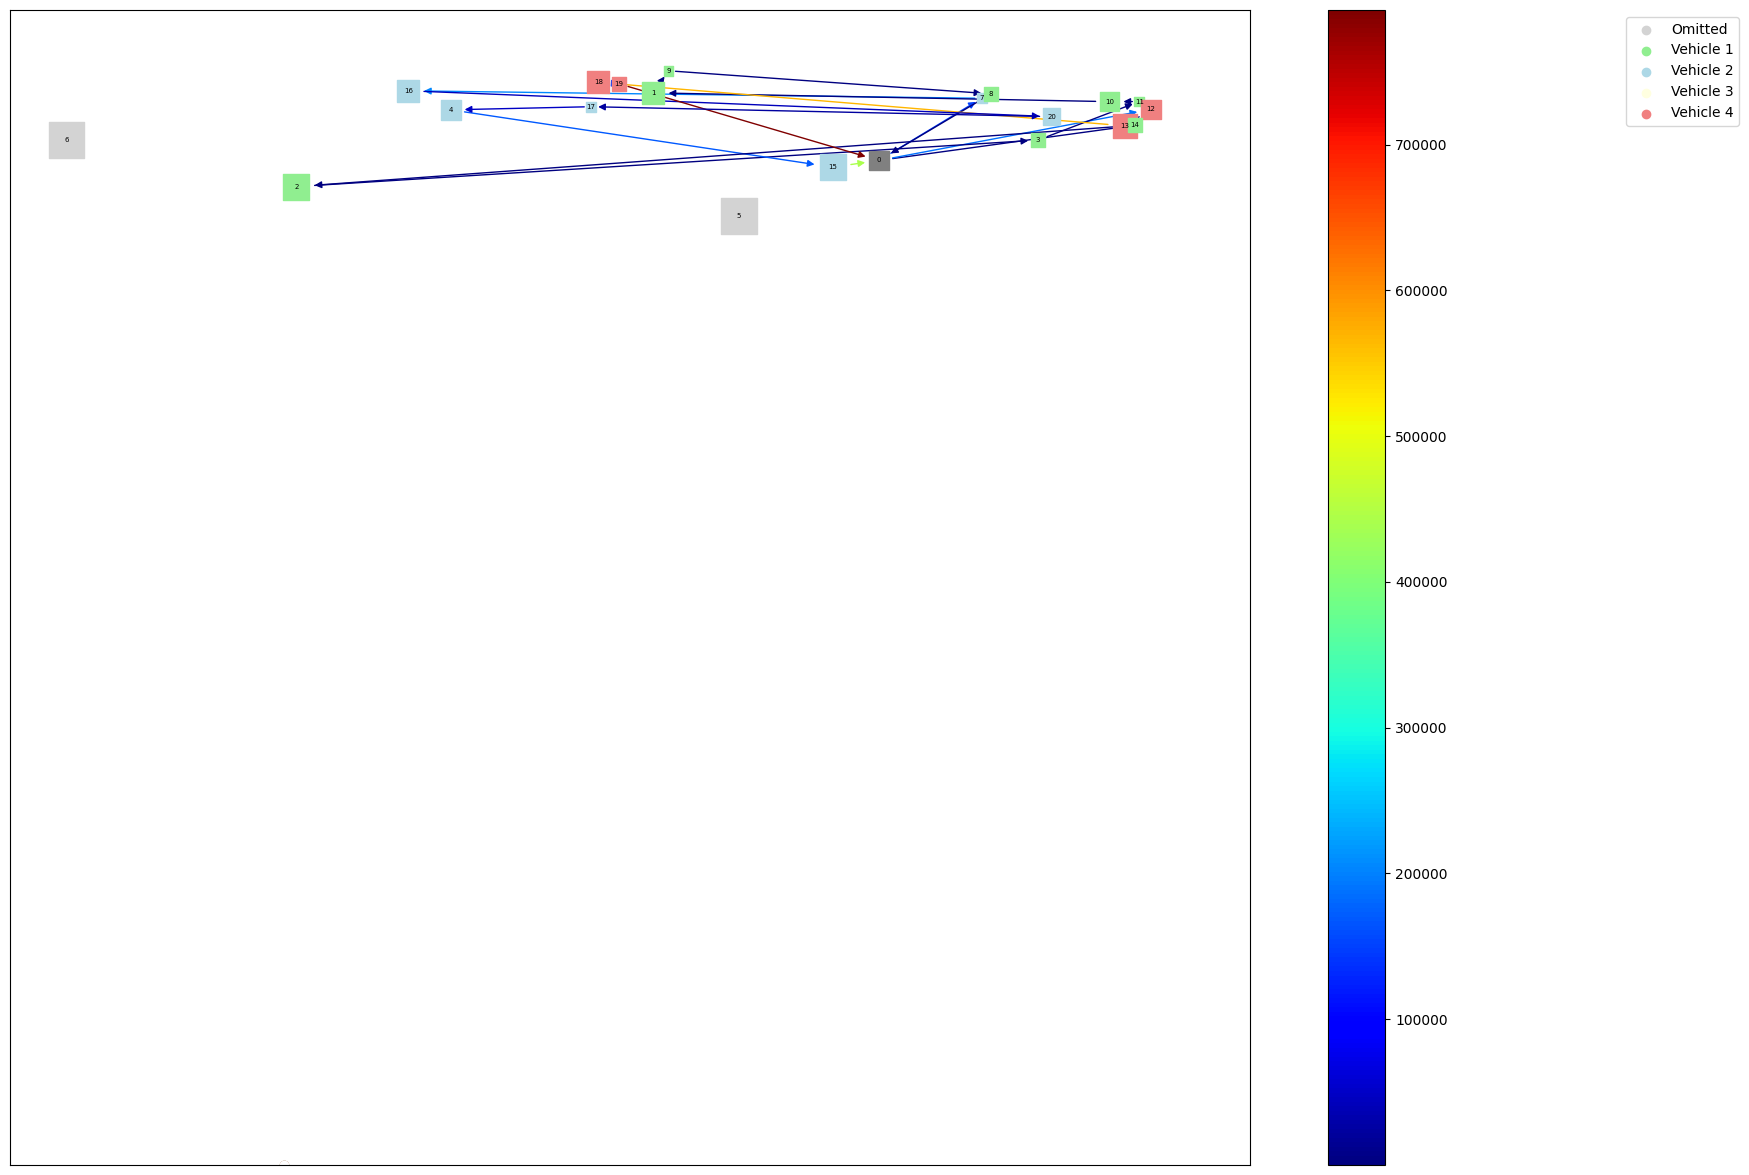

'\\documentclass{report}\n\\usepackage{tikz}\n\\usepackage{subcaption}\n\n\\begin{document}\n\\begin{figure}\n  \\begin{tikzpicture}\n      \\draw\n        (5.246, 46.205) node[gray] (0){0}\n        (3.253, 49.315) node[lightgreen] (1){1}\n        (0.106, 45.004) node[lightgreen] (2){2}\n        (6.649, 47.144) node[lightgreen] (3){3}\n        (1.469, 48.535) node[lightblue] (4){4}\n        (4.01, 43.659) node[lightgray] (5){5}\n        (-1.922, 47.149) node[lightgray] (6){6}\n        (6.153, 49.066) node[lightblue] (7){7}\n        (6.235, 49.27) node[lightgreen] (8){8}\n        (3.39, 50.33) node[lightgreen] (9){9}\n        (7.28, 48.912) node[lightgreen] (10){10}\n        (7.542, 48.917) node[lightgreen] (11){11}\n        (7.645, 48.557) node[lightcoral] (12){12}\n        (7.415, 47.799) node[lightcoral] (13){13}\n        (7.503, 47.823) node[lightgreen] (14){14}\n        (4.838, 45.898) node[lightblue] (15){15}\n        (1.095, 49.411) node[lightblue] (16){16}\n        (2.708, 48.67

In [38]:
K = 20
# game = AssignmentEnv(obs_mode='game')
# game.reset()
# with open(f'RL/game_K{K}_retain1.0.pkl', 'rb') as f:
#     g = pickle.load(f)
# routes = np.load(f'RL/routes_K{K}_retain1.0.npy')
# dests = np.load(f'RL/destinations_K{K}_retain1.0.npy')
# qs = np.load(f'RL/quantities_K{K}_retain1.0.npy')
# env = GameEnv(AssignmentEnv(game=deepcopy(g), saved_routes=routes, saved_dests=dests, saved_q=qs, obs_mode='game', instance_id=instance, change_instance=False))
instance = 3
with open(f'RL/{real}game_K{K}_retain1.0.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'RL/{real}routes_K{K}_retain1.0.npy')
dests = np.load(f'RL/{real}destinations_K{K}_retain1.0.npy')
qs = np.load(f'RL/{real}quantities_K{K}_retain1.0.npy')
env = GameEnv(AssignmentEnv(game=deepcopy(g), saved_routes=routes, saved_dests=dests,saved_q=qs, obs_mode='game', instance_id=instance, change_instance=False))
_, info = env.reset()
env.render()
# env.render()
print(info)
action = dataEXP3TSP20[instance]['solution']
# action = np.zeros(K, dtype=int)
# print(np.sum(env._env.quantities[np.where(action==0)[0]]))
*_, info = env.step(action)
nrmlz = np.sum(env.quantities)*env.omission_cost
print(info)
print((nrmlz + info['r'])/nrmlz)
# print(data['res_DP'][instance]['r'])
env.render()

action = dataSATSP20['res_SA'][instance]['sol']
# action = np.zeros(K, dtype=int)
# print(np.sum(env._env.quantities[np.where(action==0)[0]]))
*_, info = env.step(action)
nrmlz = np.sum(env.quantities)*env.omission_cost
print(info)
print((nrmlz + info['r'])/nrmlz)
# print(data['res_DP'][instance]['r'])
env.render()

In [39]:
(10*np.random.dirichlet(np.ones(10))).astype(int)

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 1])

In [40]:
action = data20['res_SA'][instance]['sol']
action

array([ 0,  1,  2,  7,  8,  9, 10, 13, 18])

In [41]:
# eenv = RemoveActionEnv(AssignmentEnv(game=deepcopy(g), saved_routes=routes, saved_dests=dests, instance_id=instance, change_instance=False))
eenv = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
                          obs_mode='elimination_gain', 
                          action_mode = 'destinations',
                            change_instance = False, rewards_mode='normalized_terminal', instance_id = instance)
action = data['res_SA'][instance]['sol']
eenv.reset()
_, r, *_, info = eenv.step(action)
# env._env.initial_routes = info['routes']
print(info)
env.reset()
env.omitted = info['omitted']-1
env.routes = np.zeros((len(env.emissions_KM), env.max_capacity+2), dtype=np.int64)
for i in range(len(info['routes'])):
    k = 1
    for j in range(2, len(info['routes'][i]), 2):
        if not info['routes'][i, j]:
            break
        env.routes[i, k] = info['routes'][i, j]
        k += 1
print(env.routes)
env.render()
# env.render()
# print(info['routes'])
# print(r)
# print(info)

IndexError: index 39 is out of bounds for axis 0 with size 20

0.7931818181818181


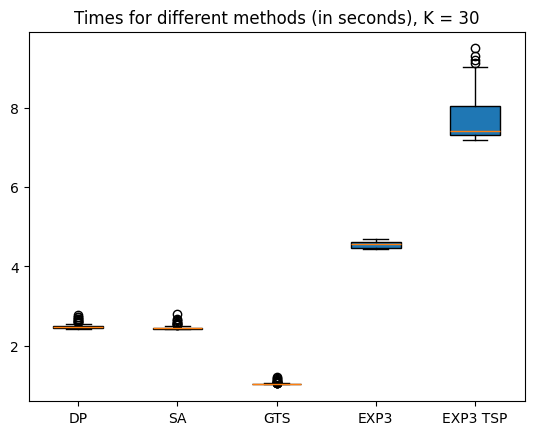

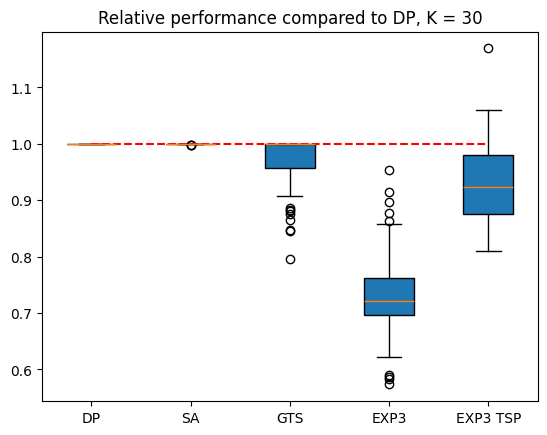

In [ ]:
with open('res_compare_EG_A*_SA_K30_n100.pkl', 'rb') as f:
    data30 = pickle.load(f)
# render_results(data100, labels=['DP', 'SA', 'A*', 'EHEG'])
with open('res_GameLearning_EXP3_K30_n100_vrp.pkl', 'rb') as f:
    dataEXP30 = pickle.load(f)
    
with open('res_GameLearning_EXP3_K30_n100_tsp.pkl', 'rb') as f:
    dataEXP3TSP30 = pickle.load(f)
    
exp30 = {
    i : {
        'r' : np.max(dataEXP30[i]['rewards']),
        'time' : dataEXP30[i]['time']
    }
    for i in dataEXP30.keys()
}

expTSP30 = {
    i : {
        'r' : np.max(dataEXP3TSP30[i]['rewards']),
        'time' : dataEXP3TSP30[i]['time']
    }
    for i in dataEXP3TSP30.keys()
}

data30['EXP3'] = exp30
data30['EXP3 TSP'] = expTSP30
render_results(data30, labels=['DP', 'SA', 'GTS', 'EXP3', 'EXP3 TSP'], K = 30)

{'whiskers': [<matplotlib.lines.Line2D at 0x321dcaa10>,
 'caps': [<matplotlib.lines.Line2D at 0x321dca380>,
 'boxes': [<matplotlib.lines.Line2D at 0x321dcabc0>],
 'medians': [<matplotlib.lines.Line2D at 0x321dc9300>],
 'fliers': [<matplotlib.lines.Line2D at 0x321dc9db0>],
 'means': []}

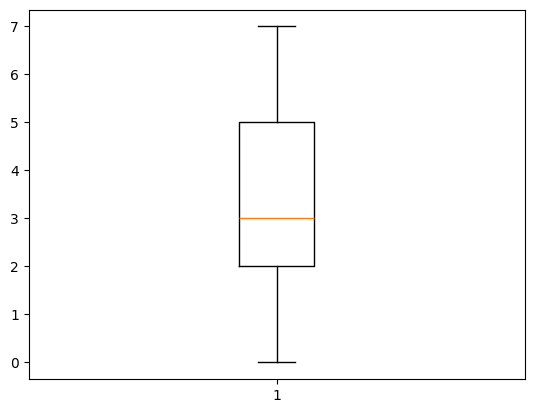

In [ ]:
plt.boxplot([len(data30['res_SA'][i]['sol']) for i in data30['res_SA'].keys()])

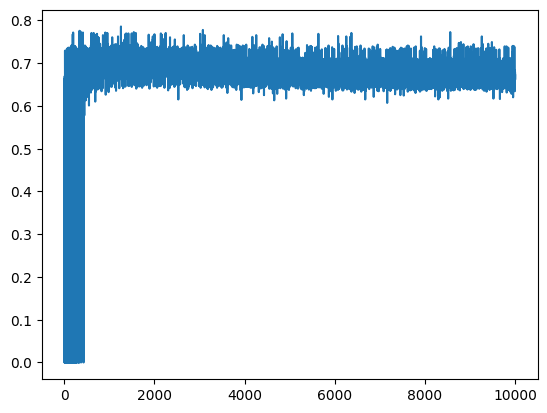

In [ ]:
plt.plot(np.maximum(0, np.max([dataEXP3TSP30[i]['rewards'][1:] for i in dataEXP3TSP30.keys()], axis=0)))

In [ ]:
dataEXP3TSP30[0]['solution']

array([2, 2, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 2, 2, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
data['res_SA'][0][0].keys()

dict_keys(['sol', 'list_best_costs'])

In [ ]:
with open('results/res_fullOR10_baseline_Q30_K50_n100_T500.pkl', 'rb') as f:
    full_OR10_data = pickle.load(f)
# full_OR10_data
with open('results/res_fullOR5_baseline_Q30_K50_n100_T500.pkl', 'rb') as f:
    full_OR5_data = pickle.load(f)
# full_OR10_data

In [ ]:
# with open('../results/res_AlphaBeta_Q30_K50_n100_T500.pkl', 'rb') as f:
#     ab_data = pickle.load(f)
# with open('../results/res_AlphaBeta3_Q30_K50_n100_T500.pkl', 'rb') as f:
#     ab3_data = pickle.load(f)
# with open('../results/res_AlphaBeta4_Q30_K50_n100_T500.pkl', 'rb') as f:
#     ab4_data = pickle.load(f)

In [ ]:
# with open('TransportersDilemma/res_A*_Q30_K50_n100_T500.pkl', 'rb') as f:
#     aStar_data = pickle.load(f)
# # with open('TransportersDilemma/results/res_A*_Q30_K100_n100_T500.pkl', 'rb') as f:
# #     aStar_Q30_K100_data = pickle.load(f)
# # with open('TransportersDilemma/results/res_A*_Q50_K100_n100_T500.pkl', 'rb') as f:
# #     aStar_Q50_K100_data = pickle.load(f)


In [ ]:
# with open('res_(A_Star)_v1_Q30_K50_n100.pkl', 'rb') as f:
#     aStar_v2 = pickle.load(f)
    
# with open('res_A*_v2_Q30_K50_n100.pkl', 'rb') as f:
#     aStar_v22 = pickle.load(f)
    
# with open('res_A*_v1_Q30_K50_n100.pkl', 'rb') as f:
#     aStar_v1 = pickle.load(f)


In [ ]:
# render_results([
#     aStar_data,
#     aStar_v1,
#     aStar_v2,
#     # aStar_v22,
# ])


In [ ]:
# with open('res_(A_Star)_woCompile_Q20_K50_n100.pkl', 'rb') as f:
#     aStar_wo = pickle.load(f)
    
# with open('res_(A_Star)_Q20_K50_n100.pkl', 'rb') as f:
#     aStar_w = pickle.load(f)

# render_results([
#     aStar_wo,
#     aStar_w,
# ])

In [ ]:
# costs_aStar = -np.array([
#     aStar_data[i]['rewards']
#     for i in aStar_data.keys()
# ])

# costs_aStar_v1 = -np.array([
#     aStar_v1[i]['rewards']
#     for i in aStar_v1.keys()
# ])

# costs_aStar_v2 = -np.array([
#     aStar_v2[i]['rewards']
#     for i in aStar_v2.keys()
# ])

# costs_aStar_v22 = -np.array([
#     aStar_v22[i]['rewards']
#     for i in aStar_v22.keys()
# ])

# costs = [
#     np.amin(np.where(costs_aStar==0, np.inf, costs_aStar), axis=1),
#     np.amin(np.where(costs_aStar_v2==0, np.inf, costs_aStar_v2), axis=1),
#     np.amin(np.where(costs_aStar_v22==0, np.inf, costs_aStar_v22), axis=1),
# ]

# print(costs_aStar.shape)
# print(costs_aStar_v2.shape)
# print(costs_aStar_v22.shape)
# plt.boxplot(
#     costs,
#     # labels=labels,
#     # patch_artist=True,
#     )

# plt.violinplot(
#     costs,
#     # labels=labels,
#     )
# plt.title(f'costs for different methods')
# # plt.savefig('times.png')
# plt.show()

In [ ]:
# times = dict()

# times['ab'] = [ab_data[i]['time'] for i in ab_data.keys()]
# # times['ab3'] = [ab3_data[i]['time'] for i in ab3_data.keys()]
# # times['ab4'] = [ab4_data[i]['time'] for i in ab4_data.keys()]
# times['aStar'] = [aStar_data[i]['time'] for i in aStar_data.keys()]
# times['aStar_v2'] = [aStar_v2[i]['time'] for i in aStar_v2.keys()]
# times['aStar_v22'] = [aStar_v22[i]['time'] for i in aStar_v22.keys()]
# times['aStar2'] = [aStar_data[i]['time'] for i in aStar_data.keys()]
# times['aStar_Q30_K100_data'] = [aStar_Q30_K100_data[i]['time'] for i in aStar_Q30_K100_data.keys()]
# times['aStar_Q50_K100_data'] = [aStar_Q50_K100_data[i]['time'] for i in aStar_Q50_K100_data.keys()]

# # times['baseline_fullOR'] = [full_OR_data[i]['time'] for i in full_OR_data.keys()]
# # times['baseline_fullOR10'] = [full_OR10_data[i]['time'] for i in full_OR10_data.keys()]
    
# labels = [
#         "a-b 2",
#         "A*",
#         "A* Q30 K100",
#         "A* Q50 K100",
#         # 'GTS full-OR',
#         # 'GTS full-OR 10',
#     ]

# # print(len(times.values()) == len(labels))
# # print((labels)) 
# plt.boxplot(
#     times.values(),
#     labels=labels,
#     # patch_artist=True,
#     )

# plt.violinplot(
#     times.values(),
#     # labels=labels,
#     )
# plt.title(f'Times for different methods (in seconds)')
# # plt.savefig('times.png')
# plt.show()

In [ ]:
# costs_aStar = -np.array([
#     aStar_data[i]['rewards']
#     for i in aStar_data.keys()
# ])

# costs_aStar_Q30_K100 = -np.array([
#     aStar_Q30_K100_data[i]['rewards']
#     for i in aStar_Q30_K100_data.keys()
# ])

# costs_aStar_Q50_K100 = -np.array([
#     aStar_Q50_K100_data[i]['rewards']
#     for i in aStar_Q50_K100_data.keys()
# ])

# costs = [
#     np.amin(np.where(costs_aStar==0, np.inf, costs_aStar), axis=1),
#     np.amin(np.where(costs_aStar_Q30_K100==0, np.inf, costs_aStar_Q30_K100), axis=1),
#     np.amin(np.where(costs_aStar_Q50_K100==0, np.inf, costs_aStar_Q50_K100), axis=1),
# ]

# plt.boxplot(
#     costs,
#     labels=labels,
#     # patch_artist=True,
#     )

# plt.violinplot(
#     costs,
#     # labels=labels,
#     )
# plt.title(f'costs for different methods')
# # plt.savefig('times.png')
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# times = {
#         k : [data[k][i]['time'] for i in data[k].keys()]
#         for k in list(data.keys())#[:2]
#     }
# print(times.keys())

# # times['ab'] = [ab_data[i]['time'] for i in ab_data.keys()]
# # times['ab3'] = [ab3_data[i]['time'] for i in ab3_data.keys()]
# # times['ab4'] = [ab4_data[i]['time'] for i in ab4_data.keys()]
# times['aStar'] = [aStar_data[i]['time'] for i in aStar_data.keys()]

# # times['baseline_fullOR'] = [full_OR_data[i]['time'] for i in full_OR_data.keys()]
# # times['baseline_fullOR10'] = [full_OR10_data[i]['time'] for i in full_OR10_data.keys()]
    
# labels = [
#         'LRI',
#         'SA',
#         # 'GTS',
#         # 'IRWDP',
#         # "a-b 2",
#         "A*",
#         # 'GTS full-OR',
#         # 'GTS full-OR 10',
#     ]

# # print(len(times.values()) == len(labels))
# # print((labels)) 
# # plt.boxplot(
# #     times.values(),
# #     labels=labels,
# #     # patch_artist=True,
# #     )

# # plt.violinplot(
# #     times.values(),
# #     # labels=labels,
# #     )
# # plt.title(f'Times for different methods (in seconds)')
# # # plt.savefig('times.png')
# # plt.show()

In [ ]:
# import numpy as np
# costs_game = -np.array([
#         data['res_game'][i]['rewards']
#         for i in data['res_game'].keys()
#     ])
    
# # costs_baseline = -np.array([
# #     data['res_baseline'][i]['rewards']
# #     for i in data['res_baseline'].keys()
# # ])

# # costs_ab = -np.array([
# #     ab_data[i]['rewards']
# #     for i in ab_data.keys()
# # ])

# # costs_ab3 = -np.array([
# #     ab3_data[i]['rewards']
# #     for i in ab3_data.keys()
# # ])

# # costs_ab4 = -np.array([
# #     ab4_data[i]['rewards']
# #     for i in ab4_data.keys()
# # ])

# costs_aStar = -np.array([
#     aStar_data[i]['rewards']
#     for i in aStar_data.keys()
# ])

# # costs_greedy = -np.array([
# #     data['res_greedy'][i]['rewards']
# #     for i in data['res_greedy'].keys()
# # ])

# costs_SA = np.amin([[
#     data['res_SA'][i][j]['list_best_costs']
#     for j in data['res_SA'][i].keys() if j != 'time'
# ] for i in data['res_SA'].keys()],
# axis=1)

# # print(costs_game.shape)
# # print(costs_SA.shape)

# costs = [
#     np.amin(costs_game, axis=1),
#     np.amin(costs_SA, axis=1),
#     # np.amin(costs_baseline, axis=1),
#     # np.amin(costs_greedy, axis=1),
#     # np.amin(np.where(costs_ab==0, np.inf, costs_ab), axis=1),
#     np.amin(np.where(costs_aStar==0, np.inf, costs_aStar), axis=1),
#     # np.amin(np.where(costs_ab3==0, np.inf, costs_ab3), axis=1),
#     # np.amin(np.where(costs_ab4==0, np.inf, costs_ab4), axis=1),
# ]

In [ ]:
# plt.boxplot(
#     costs,
#     labels=labels,
#     # patch_artist=True,
#     )

# plt.violinplot(
#     costs,
#     # labels=labels,
#     )
# plt.title(f'K = 50, Costs for different methods')
# plt.savefig('costs.png')
# plt.show()

In [ ]:
# plt.boxplot(
#     costs[1:],
#     labels=labels[1:],
#     # patch_artist=True,
#     )

# plt.violinplot(
#     costs[1:],
#     # labels=labels,
#     )
# plt.title(f'costs for different methods')
# # plt.savefig('times.png')
# plt.show()

In [ ]:
full_OR_data[0].keys()

dict_keys(['solution', 'rewards', 'excess_emission', 'infos', 'time'])

In [ ]:
# # omitted_game = np.array([
# #         data['res_game'][i]['infos']['omitted']
# #         for i in data['res_game'].keys()
# #     ])
    
# omitted_baseline = np.array([
#     data['res_baseline'][i]['infos']['omitted']
#     for i in data['res_baseline'].keys()
# ])

# omitted_greedy = np.array([
#     data['res_greedy'][i]['infos']['omitted']
#     for i in data['res_greedy'].keys()
# ])

# # omitted_SA = np.amin([[
# #     data['res_SA'][i][j]['info']
# #     for j in data['res_SA'][i].keys() if j != 'time'
# # ] for i in data['res_SA'].keys()],
# # axis=1)

# # print(costs_game.shape)
# # print(costs_SA.shape)

# omitted = [
#     # np.amin(omitted_game, axis=1),
#     # np.amin(omitted_SA, axis=1),
#     np.amin(omitted_baseline, axis=1),
#     np.amin(omitted_greedy, axis=1),
# ]

# plt.boxplot(
#     omitted,
#     # labels=labels,
#     # patch_artist=True,
#     )

# plt.violinplot(
#     omitted,
#     # labels=labels,
#     )
# plt.title(f'costs for different methods')
# # plt.savefig('times.png')
# plt.show()

In [ ]:
import pickle
with open('../results/res_semiOR_compare_baseline_greedy_SA_LRI_Q30_K50_n100_T500.pkl', 'rb') as f:
    data = pickle.load(f)
    
with open('../results/res_fullOR1_baseline_Q30_K50_n100_T500.pkl', 'rb') as f:
    full_OR_data = pickle.load(f)
    
import numpy as np

costs_semiOR = -np.array([
        data['res_baseline'][i]['rewards']
        for i in data['res_baseline'].keys()
    ])

costs_fullOR = -np.array([
        full_OR_data[i]['rewards']
        for i in full_OR_data.keys()
    ])
# costs_fullOR5 = -np.array([
#         full_OR5_data[i]['rewards']
#         for i in full_OR5_data.keys()
#     ])
# costs_fullOR10 = -np.array([
#         full_OR10_data[i]['rewards']
#         for i in full_OR10_data.keys()
#     ])

Text(0.5, 1.0, 'Performance ratio between static and dynamic OR using GTS')

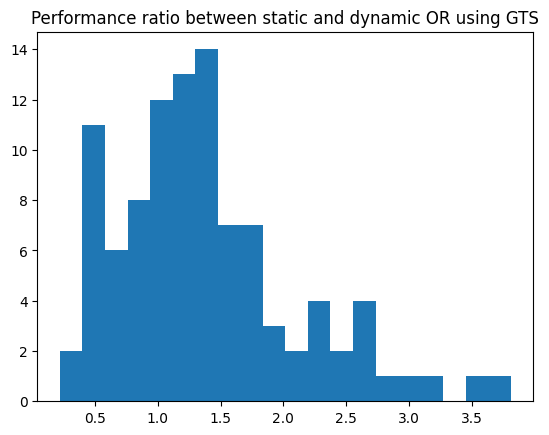

In [ ]:
plt.hist(np.amin(costs_semiOR, axis=1)/np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1), density=False, bins=20)
plt.title('Performance ratio between static and dynamic OR using GTS')

ValueError: Dimensions of labels and X must be compatible

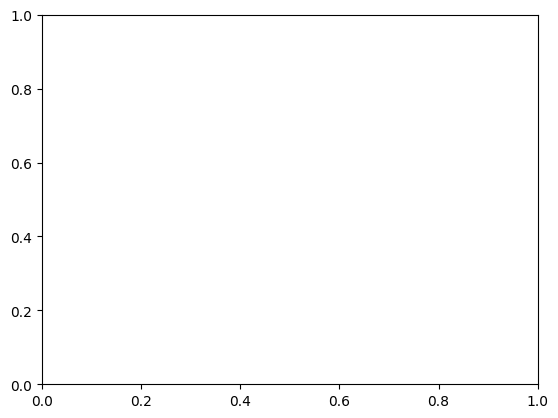

In [ ]:
# import matplotlib.pyplot as plt
# plt.boxplot(
#     [
#         np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1)/np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
#         np.amin(costs_semiOR, axis=1)/np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
#         # np.amin(np.where(costs_fullOR5==0, np.inf, costs_fullOR5), axis=1)/np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
#         # np.amin(np.where(costs_fullOR10==0, np.inf, costs_fullOR10), axis=1)/np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
#     ],
#     labels=['full', 'semi', 'OR every 5 steps', 'OR every 10'],
#     # patch_artist=True
# )

# plt.violinplot(
#     [
#         np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1)/np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
#         np.amin(costs_semiOR, axis=1)/np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
#         # np.amin(np.where(costs_fullOR5==0, np.inf, costs_fullOR5), axis=1)/np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
#         # np.amin(np.where(costs_fullOR10==0, np.inf, costs_fullOR10), axis=1)/np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
#     ],
# # labels=labels,
# )
# # plt.title(f'Costs for different methods : Q={30}, K={50}, n={100}')

Text(0.5, 1.0, 'Times (seconds) for different methods : Q=30, K=50, n=100')

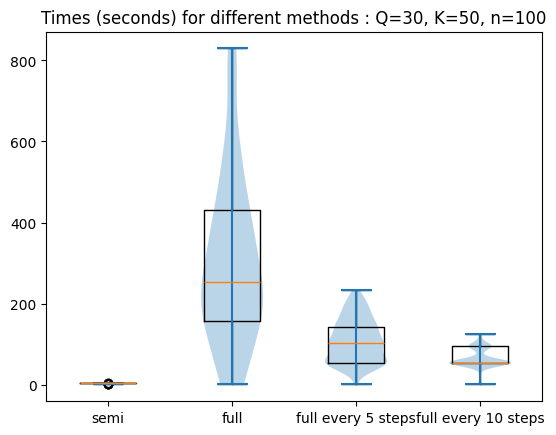

In [ ]:
plt.boxplot(
        [
            [data['res_baseline'][i]['time'] for i in full_OR_data.keys()],
            [full_OR_data[i]['time'] for i in full_OR_data.keys()],
            [full_OR5_data[i]['time'] for i in full_OR5_data.keys()],
            [full_OR10_data[i]['time'] for i in full_OR_data.keys()],
        ],
        labels=['semi', 'full', 'full every 5 steps', 'full every 10 steps'],
        # patch_artist=True
        )
plt.violinplot(
        [
            [data['res_baseline'][i]['time'] for i in full_OR_data.keys()],
            [full_OR_data[i]['time'] for i in full_OR_data.keys()],
            [full_OR5_data[i]['time'] for i in full_OR5_data.keys()],
            [full_OR10_data[i]['time'] for i in full_OR_data.keys()],
        ],
    # labels=labels,
    )
plt.title(f'Times (seconds) for different methods : Q={30}, K={50}, n={100}')

## Omitted packages

In [ ]:
full_OR_data[0]['infos']

In [ ]:
omitted_fullOR = np.array([
        full_OR_data[i]['infos']['omitted']
        for i in full_OR_data.keys()
    ])
omitted_fullOR5 = np.array([
        full_OR5_data[i]['infos']['omitted']
        for i in full_OR5_data.keys()
    ])
omitted_fullOR10 = np.array([
        full_OR10_data[i]['infos']['omitted']
        for i in full_OR10_data.keys()
    ])


plt.boxplot(
    [
        omitted_fullOR,# np.amin(costs_baseline, axis=1),
        omitted_fullOR5,# np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
        omitted_fullOR10,# np.amin(np.where(costs_fullOR5==0, np.inf, costs_fullOR5), axis=1),
        # np.amin(np.where(costs_fullOR10==0, np.inf, costs_fullOR10), axis=1),
    ],
    labels=['full', 'full every 5 steps', 'full every 10 steps'],
    # patch_artist=True
)

plt.violinplot(
    [
        omitted_fullOR,# np.amin(costs_baseline, axis=1),
        omitted_fullOR5,# np.amin(np.where(costs_fullOR==0, np.inf, costs_fullOR), axis=1),
        omitted_fullOR10,# np.amin(np.where(costs_fullOR5==0, np.inf, costs_fullOR5), axis=1),
        # np.amin(np.where(costs_fullOR10==0, np.inf, costs_fullOR10), axis=1),
    ],
# labels=labels,
)
plt.title(f'Costs for different methods : Q={30}, K={50}, n={100}, T={500}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
from time import time

t = time()
a = np.ones(500)
print(a@a.T)
print('took : ', time() - t)


In [ ]:
import multiprocess as mp
mp.cpu_count()

In [ ]:
def f(l, i):
    l.append(i)
    print(l)

def g():
    for i in range(5):
        l = []
        f(l, i)

g()

In [ ]:
import datetime
str(datetime.datetime.now().strftime("%H:%M:%S_%d-%m-%Y"))

In [ ]:
T = 30
shares = 1000*np.ones(T)
capitalist = shares.copy()
dilution_rate = 0.2
workers = np.zeros(T)

for t in range(1, T):
    workers[t] = workers[t-1] + shares[t-1]*dilution_rate
    shares [t]= workers[t]+capitalist[t]

plt.plot(workers/shares, label="workers shares")
plt.plot(capitalist/shares, label="capitalist shares")
plt.title("How many years of dilution ?")
plt.ylabel("Share")
plt.xlabel("years")
plt.legend()
print(100*workers/shares)
print(100*capitalist/shares)

In [ ]:
GOAL = 1e9
incomes = np.arange(1e7)+1
years = GOAL/incomes

In [ ]:
plt.loglog(incomes, years, label="years needed")
plt.hlines(45, 1, incomes[-1], colors='red', label="45 years of possible work")
plt.title("How many years of salary income to become a billionnaire ?")
plt.scatter(incomes[-1], years[-1], color="black", label="100 years needed with an annual 10M income !!!!")
plt.ylabel("Years")
plt.xlabel("Annual Income")
plt.legend()

In [ ]:
def simulation(
    T = 10_000,
    eps = 1e-3,
    BASE = 1.01,
    initial_share = np.array([.25, .30, .4, .05]),
):
    GROWTH = np.array([BASE+3*eps, BASE+2*eps, BASE+eps, BASE])
    wealth_share = initial_share
    history = np.zeros((T, 4))
    GDP = 1_000
    wealth = GDP*wealth_share
    for t in range(T):
        history[t, :] = wealth_share
        wealth *= GROWTH
        # print(wealth)
        GDP = np.sum(wealth)
        wealth_share = wealth/GDP
    
    return history
        

In [ ]:
res = simulation(T = 1000, BASE = .98, eps=0.02, initial_share=np.array([.51, .35, .13, .01]))

In [ ]:
import matplotlib.pyplot as plt
y = np.vstack(res)
# print(y.shape)
classes = {
    'Bourgeoisie 1%': np.array([1]),
    'Petite-bourgeoisie 9%': np.array([9]),
    'Middle class 40%': np.array([40]),
    'Bottom 50%': np.array([50]),
}
width = 0.6  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(1, 2)
bottom = np.zeros(3)

for classe, share in classes.items():
    p = ax[0].bar(['Share'], share, width, label=classe, bottom=bottom)
    bottom += share

    ax[0].bar_label(p, label_type='center')

ax[0].set_title('Different population classes')
ax[0].legend()
plt.show()

plt.stackplot(np.arange(len(y)), y.T, labels=list(classes.keys()))
plt.title('Wealth share evolution')
plt.legend()

In [ ]:
actions = [0, 2]
a = np.arange(5)
costs = np.ones(2)
b = [
    np.argmax(
            a
            >=
            np.maximum(costs[i], a[actions[i]])
    )
    for i in range(len(actions))
]
b

In [ ]:
%timeit f()